## w207 Final Project
### Zillow Home Prize Kaggle Competition
Matt Nelson & Andres Borrero, August 2017

In [1]:
# General libraries.
import numpy as np
import pandas as pd
import re
import datetime
import time

# Libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb

#Plotting
%matplotlib inline
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from IPython.display import Image
import gc
gc.enable()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load

In [2]:
training = pd.read_csv(r"./Data/train_2016_v2.csv")#, parse_dates=["transactiondate"])   #The parcelid's with their outcomes
properties = pd.read_csv(r"./Data/properties_2016.csv")  #The properties dataset
submission_example = pd.read_csv(r"./Data/sample_submission.csv")  #The parcelid's for the testset

#Reduce size of properties data by converting float64s to float32s
for column, dtype in zip(properties.columns, properties.dtypes):
    if dtype == np.float64:
        properties[column] = properties[column].astype(np.float32)
        
# Join Property information and Training Information into one dataframe
all_data = training.loc[:, ['parcelid', 'logerror']].merge(properties, how='left', left_on='parcelid', right_on='parcelid')
training_data_for_submission = submission_example.loc[:, ['ParcelId']].merge(properties, how='left', left_on='ParcelId', right_on='parcelid').drop(['parcelid', 'ParcelId'],axis=1,inplace=False)

properties_data = properties.drop(['parcelid'],axis=1,inplace=False)

print("Shape of Properties Data:", properties.shape)
print("Shape of Training Data:", training.shape)
print("Shape of all_data:", all_data.shape)
print("Shape of submission data:", training_data_for_submission.shape)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape of Properties Data: (2985217, 58)
Shape of Training Data: (90275, 3)
Shape of all_data: (90275, 59)
Shape of submission data: (2985217, 57)


### Shuffle and Split Data 

In [3]:
# Shuffle Data in order to randomize Train & Test selection
all_data = all_data.sample(frac=1)

# Reduce size of dataset (for now)
# all_data = all_data[:1000]

# Separate into data & labels
all_data_properties = all_data.drop(['parcelid','logerror'],axis=1,inplace=False)
all_data_labels = all_data['logerror']

In [4]:
print(all_data_properties.columns.values.shape)
print(properties_data.columns.values.shape)

(57,)
(57,)


# Explore & Preprocess

### Additional Feature Creation

In [5]:
# Inspired by Kernel: https://www.kaggle.com/nikunjm88/creating-additional-features


def feature_creation(all_data_properties):
    
    # # of NA's originally
    # all_data_properties['N-NAs'] = np.sum(
    
    # Low Outlier Logloss
    # High Outlier Logloss

    # Life of property
    all_data_properties['N-life'] = 2018 - all_data_properties['yearbuilt']

    # Error in calculation of the finished living area of home
    all_data_properties['N-LivingAreaError'] = all_data_properties['calculatedfinishedsquarefeet']/all_data_properties['finishedsquarefeet12']

    # Proportion of living area
    all_data_properties['N-LivingAreaProp'] = all_data_properties['calculatedfinishedsquarefeet']/all_data_properties['lotsizesquarefeet']
    all_data_properties['N-LivingAreaProp2'] = all_data_properties['finishedsquarefeet12']/all_data_properties['finishedsquarefeet15']

    # Amount of extra space
    all_data_properties['N-ExtraSpace'] = all_data_properties['lotsizesquarefeet'] - all_data_properties['calculatedfinishedsquarefeet'] 
    all_data_properties['N-ExtraSpace-2'] = all_data_properties['finishedsquarefeet15'] - all_data_properties['finishedsquarefeet12'] 

    # Total number of rooms
    all_data_properties['N-TotalRooms'] = all_data_properties['bathroomcnt'] + all_data_properties['bedroomcnt']

    # Average room size
    # all_data_properties['N-AvRoomSize'] = all_data_properties['calculatedfinishedsquarefeet']/all_data_properties['roomcnt'] 

    # Number of Extra rooms
    all_data_properties['N-ExtraRooms'] = all_data_properties['roomcnt'] - all_data_properties['N-TotalRooms'] 

    # Location 
    all_data_properties["N-location"] = all_data_properties["latitude"] + all_data_properties["longitude"]
    # all_data_properties["N-location-2"] = all_data_properties["latitude"]*all_data_properties["longitude"]

    # Length of time since unpaid taxes
    all_data_properties['N-life'] = 2018 - all_data_properties['taxdelinquencyyear']

    # Number of properties in the zip
    zip_count = all_data_properties['regionidzip'].value_counts().to_dict()
    all_data_properties['N-zip_count'] = all_data_properties['regionidzip'].map(zip_count)

    # Number of properties in the city
    city_count = all_data_properties['regionidcity'].value_counts().to_dict()
    all_data_properties['N-city_count'] = all_data_properties['regionidcity'].map(city_count)

    # Indicator whether it has AC or not
    all_data_properties['N-ACInd'] = (all_data_properties['airconditioningtypeid']!=5)*1

    # Indicator whether it has Heating or not 
    all_data_properties['N-HeatInd'] = (all_data_properties['heatingorsystemtypeid']!=13)*1


    # Reset new types as float32 to save space
    for column, dtype in zip(all_data_properties.columns, all_data_properties.dtypes):
        if dtype == np.float64 or dtype == np.int:
            all_data_properties[column] = all_data_properties[column].astype(np.float32)
        
    return all_data_properties

all_data_properties = feature_creation(all_data_properties)
properties_data = feature_creation(properties_data)


### Decide which variables should be considered categorical variables

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


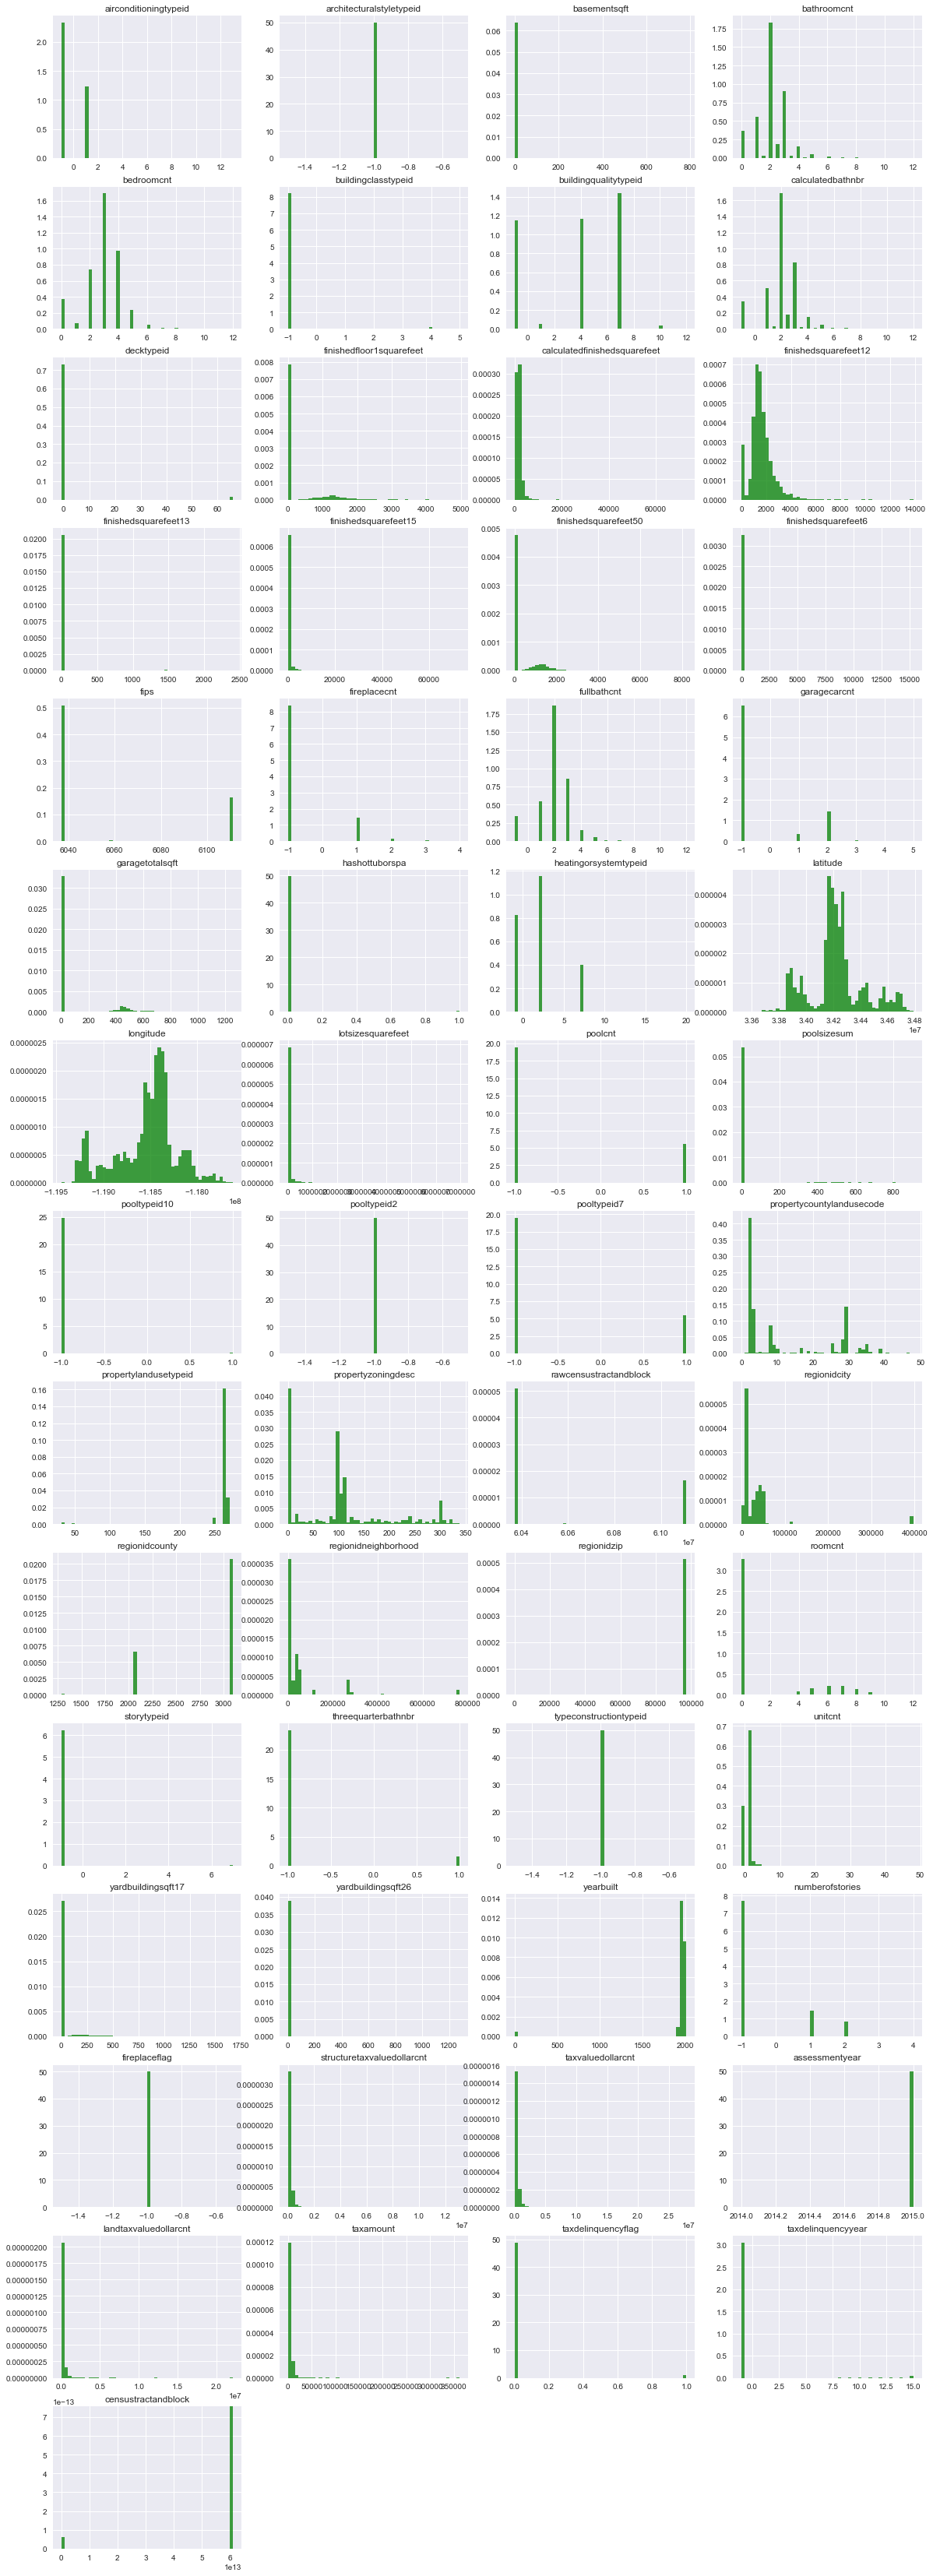

In [6]:
# Print out a histogram plot for each variable to look at the distribution

# Use a subset of all data points to speed up printing
test_print = properties[:4000]
variable_names = properties.columns.values.tolist()
variable_names = variable_names[1:]

# Impute missing data as -1's & Encode String Objects (so we can chart)
for c in test_print.columns:
    test_print[c]=test_print[c].fillna(-1)
    if test_print[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(test_print[c].values))
        test_print[c] = lbl.transform(list(test_print[c].values))

# Print out Plots
plt.figure(figsize=(20,80))
plot_count = 1
for each in variable_names:
    p = plt.subplot(20, 4, plot_count)
    p.hist(test_print[each], 50, normed=1, facecolor='g', alpha=0.75)
    plt.title(each)
    plot_count += 1

# Identify Categorical Variables (comment out those that are not, use plots above to decide)
# Also include String Variables here
cat_variable_names = ['airconditioningtypeid', 
                      'architecturalstyletypeid', 
#                       'basementsqft', 
                      'bathroomcnt', 
                      'bedroomcnt', 
                      'buildingclasstypeid', 
                      'buildingqualitytypeid', 
                      'calculatedbathnbr', 
                      'decktypeid', 
#                       'finishedfloor1squarefeet', 
#                       'calculatedfinishedsquarefeet',
#                       'finishedsquarefeet12',
#                       'finishedsquarefeet13',
#                       'finishedsquarefeet15', 
#                       'finishedsquarefeet50', 
#                       'finishedsquarefeet6', 
                      'fips', 
                      'fireplacecnt', 
                      'fullbathcnt', 
                      'garagecarcnt', 
#                       'garagetotalsqft', 
#                       'hashottuborspa', #STRING
                      'heatingorsystemtypeid', 
#                       'latitude',
#                       'longitude',
#                       'lotsizesquarefeet',
                      'poolcnt',
#                       'poolsizesum',
                      'pooltypeid10',
                      'pooltypeid2',
                      'pooltypeid7',
#                       'propertycountylandusecode', #STRING
                      'propertylandusetypeid',
#                       'propertyzoningdesc', #STRING
                      'rawcensustractandblock', 
                      'regionidcity', # Keep as categorical
                      'regionidcounty', # Keep as categorical
                      'regionidneighborhood', # Keep as categorical
                      'regionidzip', # Keep as categorical
                      'roomcnt',
                      'storytypeid',
                      'threequarterbathnbr',
                      'typeconstructiontypeid',
                      'unitcnt',
#                       'yardbuildingsqft17',
#                       'yardbuildingsqft26',
                      'yearbuilt',
                      'numberofstories',
#                       'fireplaceflag', #STRING
#                       'structuretaxvaluedollarcnt',
#                       'taxvaluedollarcnt',
                      'assessmentyear',
#                       'landtaxvaluedollarcnt',
#                       'taxamount',
#                       'taxdelinquencyflag', #STRING
                      'taxdelinquencyyear']
#                       'censustractandblock']


### Make a copy of all datasets before preprocessing begins

In [7]:
all_data_properties1 = all_data_properties.copy()
all_data_properties2 = all_data_properties.copy()
all_data_labels1 = all_data_labels[:]
properties_data1 = properties_data.copy()

print("Shape of All Properties Data:", all_data_properties1.shape)
print("Shape of All Properties Data:", properties_data1.shape)

Shape of All Properties Data: (90275, 70)
Shape of All Properties Data: (2985217, 70)


# Attempted two different Preprocessing paths 
#### Using One Hot Encoding & KNN Imputation in different orders

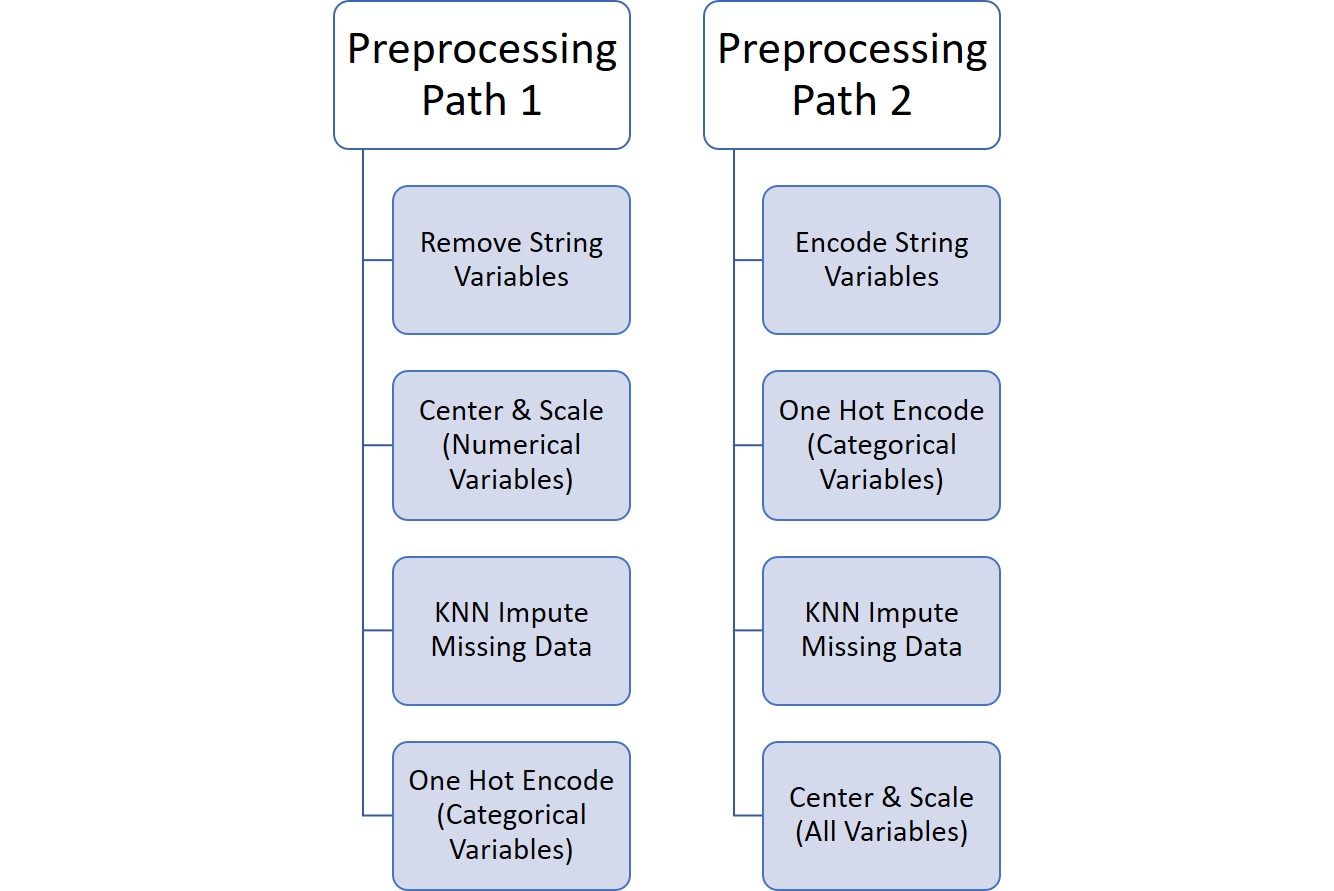

In [8]:
Image(filename = 'c:/Users/User/Documents/Berkeley/machine_learning/Final_Project_Working_Folder/Picture3.jpg', width=800, height=1000)

# PREPROCESSING PATH 1:

### Remove String Variables

In [9]:
def remove_strings(dataset):

    dataset = dataset.drop(['propertycountylandusecode'], axis=1, inplace=False)
    dataset = dataset.drop(['hashottuborspa'], axis=1, inplace=False)
    dataset = dataset.drop(['propertyzoningdesc'], axis=1, inplace=False)
    dataset = dataset.drop(['fireplaceflag'], axis=1, inplace=False)
    dataset = dataset.drop(['taxdelinquencyflag'], axis=1, inplace=False)
    dataset = dataset.select_dtypes(exclude=[object]) 
    return dataset
    
all_data_properties1 = remove_strings(all_data_properties1)
properties_data1 = remove_strings(properties_data1)

In [10]:
print("Shape of All Properties Data:", all_data_properties1.shape)
print("Shape of All Properties Data:", properties_data1.shape)

Shape of All Properties Data: (90275, 65)
Shape of All Properties Data: (2985217, 65)


### Impute all Missing Values with a -1 (or 9999 for categorical variables) for now

In [11]:
# Replace all -1s with 9999 in categorical variables in order to onehotencode properly (can't have negatives)
replacement_dictionary = {}
for label in cat_variable_names:
    replacement_dictionary[label] = {-1: 9999}

def preprocessing_step(dataset):

    # Replace ALL missing values with a -1
    dataset = dataset.fillna(-1,inplace=False)

    # Replace all -1s with 9999 in categorical variables in order to onehotencode properly (can't have negatives)
    dataset = dataset.replace(replacement_dictionary, inplace=False)
    return dataset
    
all_data_properties1 = preprocessing_step(all_data_properties1)
properties_data1 = preprocessing_step(properties_data1) 



In [12]:
print("Number of NA's Remaining: %i" %sum(all_data_properties1.loc[:,:].isnull().sum(axis=0)))
print("Number of NA's Remaining: %i" %sum(properties_data1.loc[:,:].isnull().sum(axis=0)))

Number of NA's Remaining: 0
Number of NA's Remaining: 0


### Identify Categorical Variables & their Indices

In [13]:
# Boolean List of Categorical Variables (needed to use one-hot encoding)
variable_names = properties_data1.columns.values.tolist()
boolean_catlabels = [x in cat_variable_names for x in variable_names]
boolean_inverse_catlabels = [not i for i in boolean_catlabels]

# List of indices for all category variables
category_labels_index = []
for i,j in enumerate(boolean_catlabels):
    if j == True:
        category_labels_index.append(i)

# List of indices for all non category variables        
non_category_labels_index = []
for i,j in enumerate(boolean_catlabels):
    if j == False:
        non_category_labels_index.append(i)

non_cat_variable_names = [str(variable_names[i]) for i in non_category_labels_index]



### Center and Scale all Values

In [14]:
# Center and Scale Numerical Variables
# properties_data = properties_data.select_dtypes(exclude=[object]) 
scale = StandardScaler(with_mean = True)

scale.fit(properties_data1.loc[:,non_cat_variable_names])

properties_data1.loc[:,non_cat_variable_names] = scale.transform(properties_data1.loc[:,non_cat_variable_names])
all_data_properties1.loc[:,non_cat_variable_names] = scale.transform(all_data_properties1.loc[:,non_cat_variable_names])

print("Shape of All Data:",properties_data1.shape)
print("Shape of All Data:",all_data_properties1.shape)

Shape of All Data: (2985217, 65)
Shape of All Data: (90275, 65)


### Impute missing Data using KNN

In [15]:
def knn_impute(dataset, target_variable_list, helpful_variable_list):
    ''' 
    Function to impute values for a list of target variables (in the preprocessed dataframe) using only 
    the columns of variables highly correlated with it.
    '''
    
    target_variable = target_variable_list[0]
    
    # Copy all_data_properties table and Null out non-helpful columns (but keep in because we need them to one-hot-encode properly)
    # Preprocessing Steps prior to one-hot-encoding (to get original indices minus removed columns)
    all_data_properties_temp = all_data_properties
    all_data_properties_temp = all_data_properties_temp.select_dtypes(exclude=[object]) 
    all_data_properties_temp.fillna(-1,inplace=True)
    all_data_properties_temp.replace(replacement_dictionary, inplace=True)
      
    # Reference lists with both variable names and indices of those variables
    variable_names_temp = all_data_properties_temp.columns.values.tolist()
    boolean_catlabels_temp = [x in cat_variable_names for x in variable_names]
    boolean_inverse_catlabels_temp = [not i for i in boolean_catlabels]
    
    category_labels_index_temp = []
    for i,j in enumerate(boolean_catlabels_temp):
        if j == True:
            category_labels_index_temp.append(i)    
    
    non_category_labels_index_temp = [] 
    for i,j in enumerate(boolean_catlabels_temp):
        if j == False:
            non_category_labels_index_temp.append(i)
            
    non_cat_variable_names = [str(variable_names[i]) for i in non_category_labels_index]

    # Identify Indices of data points we have information for
    all_indices = [i for i in range(dataset.shape[0])]
    known_indices = [i for i,x in enumerate(all_data_properties_temp[target_variable].values) if x != -1 and x != 9999]
    unknown_indices = [i for i,x in enumerate(all_data_properties_temp[target_variable].values) if x == -1 or x == 9999]
    column_indices = [i for i,x in enumerate(variable_names) if x in helpful_variable_list]
    target_index = [i for i,x in enumerate(variable_names) if x == target_variable]

    # Set KNN Training Data (existing data)
    temp_dataset = dataset.copy() 
    temp_dataset[np.ix_(all_indices,column_indices)] = temp_dataset[np.ix_(all_indices,column_indices)].astype(np.float32)
    knn_impute_x = temp_dataset[np.ix_(known_indices,column_indices)]
    
    if len(known_indices) < 100:
        knn = len(known_indices)*0.8
    else:
        knn = 100
    
    # Decide on Regression or Classification for each variable
    if target_variable in non_cat_variable_names:
        temp_dataset[np.ix_(all_indices,target_index)] =temp_dataset[np.ix_(all_indices,target_index)].astype(np.float32)
        knn_impute = KNeighborsRegressor(n_neighbors=knn)
    else:
        temp_dataset[np.ix_(all_indices,target_index)] =temp_dataset[np.ix_(all_indices,target_index)].astype(np.object)#.astype("|S6")
        knn_impute = KNeighborsClassifier(n_neighbors=knn)

    # Start
    print("# of populated rows for target variable: %i \t # Unpopulated Rows: %i" %(len(known_indices), len(unknown_indices)))
    print("Using kNN to Impute missing values for %s" %(target_variable))
       
    # Set Training Labels (existing data)
    knn_impute_y = temp_dataset[np.ix_(known_indices,target_index)]

    # Set Test Data (missing data)
    knn_impute_new_data = temp_dataset[np.ix_(unknown_indices,column_indices)]

    # Fit KNN model
    knn_impute.fit(knn_impute_x, knn_impute_y)

    # Impute missing data by using KNN prediction
    start = time.time()
    predictions = knn_impute.predict(knn_impute_new_data)
    predictions = np.reshape(np.array(predictions),(predictions.shape[0],1))
    dataset[np.ix_(unknown_indices,target_index)] = predictions
    print("Finished. Elapsed Time: %0.1f minutes" %((time.time()-start)/60))
    print("")

#         break ## REMOVE WHEN WE WANT TO RUN THROUGH ALL MISSING COLUMNS





In [16]:
all_data_properties1 = np.array(all_data_properties1)

for variable in variable_names[1:]:
    # variables to impute on
#     if variable in ['airconditioningtypeid', 
    if variable in ['architecturalstyletypeid', 
                      'basementsqft', 
                      'bathroomcnt', 
                      'bedroomcnt', 
                      'buildingclasstypeid', 
                      'buildingqualitytypeid', 
                      'calculatedbathnbr', 
#                       'decktypeid', 
                      'finishedfloor1squarefeet', 
                      'calculatedfinishedsquarefeet',
                      'finishedsquarefeet12',
                      'finishedsquarefeet13',
                      'finishedsquarefeet15', 
                      'finishedsquarefeet50', 
                      'finishedsquarefeet6', 
#                       'fips', 
#                       'fireplacecnt', 
                      'fullbathcnt', 
                      'garagecarcnt', 
                      'garagetotalsqft', 
#                       'hashottuborspa', #STRING
                      'heatingorsystemtypeid', 
                      'latitude',
                      'longitude',
                      'lotsizesquarefeet',
#                       'poolcnt',
#                       'poolsizesum',
#                       'pooltypeid10',
#                       'pooltypeid2',
#                       'pooltypeid7',
#                       'propertycountylandusecode', #STRING
                      'propertylandusetypeid',
#                       'propertyzoningdesc', #STRING
                      'rawcensustractandblock', 
                      'regionidcity', # Keep as categorical
                      'regionidcounty', # Keep as categorical
                      'regionidneighborhood', # Keep as categorical
                      'regionidzip', # Keep as categorical
                      'roomcnt',
                      'storytypeid',
                      'threequarterbathnbr',
#                       'typeconstructiontypeid',
#                       'unitcnt',
                      'yardbuildingsqft17',
                      'yardbuildingsqft26',
                      'yearbuilt',
                      'numberofstories',
#                       'fireplaceflag', #STRING
                      'structuretaxvaluedollarcnt',
                      'taxvaluedollarcnt',
                      'assessmentyear',
                      'landtaxvaluedollarcnt',
                      'taxamount',
#                       'taxdelinquencyflag', #STRING
#                       'taxdelinquencyyear',
                    'censustractandblock']:
        current_variable = [i for i in variable_names if i == variable]
        remaining_variable_list = [i for i in variable_names if i != variable]
        try:
            knn_impute(all_data_properties1, current_variable, remaining_variable_list)
#         break ## REMOVE WHEN WE WANT TO RUN THROUGH ALL MISSING COLUMNS
        except:
            continue
    else:
        continue
        
        
    #     break ## REMOVE WHEN WE WANT TO RUN THROUGH ALL MISSING COLUMNS


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3855: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


# of populated rows for target variable: 261 	 # Unpopulated Rows: 90014
Using kNN to Impute missing values for architecturalstyletypeid


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Finished. Elapsed Time: 0.1 minutes

# of populated rows for target variable: 43 	 # Unpopulated Rows: 90232
Using kNN to Impute missing values for basementsqft


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:360: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  neigh_ind = neigh_ind[:, :n_neighbors]


Finished. Elapsed Time: 0.0 minutes

# of populated rows for target variable: 90275 	 # Unpopulated Rows: 0
Using kNN to Impute missing values for bathroomcnt
# of populated rows for target variable: 90275 	 # Unpopulated Rows: 0
Using kNN to Impute missing values for bedroomcnt
# of populated rows for target variable: 16 	 # Unpopulated Rows: 90259
Using kNN to Impute missing values for buildingclasstypeid
Finished. Elapsed Time: 0.0 minutes

# of populated rows for target variable: 57364 	 # Unpopulated Rows: 32911
Using kNN to Impute missing values for buildingqualitytypeid
Finished. Elapsed Time: 0.5 minutes

# of populated rows for target variable: 89093 	 # Unpopulated Rows: 1182
Using kNN to Impute missing values for calculatedbathnbr
# of populated rows for target variable: 6856 	 # Unpopulated Rows: 83419
Using kNN to Impute missing values for finishedfloor1squarefeet
Finished. Elapsed Time: 0.3 minutes

# of populated rows for target variable: 89614 	 # Unpopulated Rows: 661


### One Hot Encode all Categorical Variables

In [15]:
# Re-convert to float32
# for column, dtype in zip(all_data_properties1.columns, all_data_properties1.dtypes):
#     if dtype == np.float64:
#         all_data_properties1[column] = all_data_properties1[column].astype(np.float32)
#     if dtype == np.int:
#         all_data_properties1[column] = all_data_properties1[column].astype(np.float32)


# Fit One Hot Encoder to full dataset (on only categorical variables)
enc = OneHotEncoder(categorical_features=boolean_catlabels, sparse=False, handle_unknown = 'ignore')
properties_data1 = properties_data1.fillna(-1,inplace=False)
enc.fit(properties_data1[:1000000]) # Reduce the size so it can fit into memory

all_data_properties1 = enc.transform(all_data_properties1)
print("Shape of All Data:", all_data_properties1.shape)

Shape of All Data: (90275, 2136)


# PREPROCESSING PATH 2: 

### Encode Strings

In [18]:
# # Impute missing data as -1's & Encode String Objects (to chart)
for c in all_data_properties2.columns:
    if all_data_properties2[c].dtype == 'object':
        all_data_properties2[c] = all_data_properties2[c].fillna(0,inplace=False)
        lbl = LabelEncoder()
        lbl.fit(list(all_data_properties2[c].values))
        all_data_properties2[c] = lbl.transform(list(all_data_properties2[c].values))
        
        

### Impute all Missing Values with a -1 (or 9999 for categorical variables) for now

In [19]:
# Replace ALL missing values with a -1
all_data_properties2 = all_data_properties2.fillna(-1,inplace=False)

# Replace all -1s with 9999 in categorical variables in order to onehotencode properly (can't have negatives)
replacement_dictionary = {}
for label in cat_variable_names:
    replacement_dictionary[label] = {-1: 9999}
all_data_properties2 = all_data_properties2.replace(replacement_dictionary, inplace=False)

print("Number of NA's Remaining: %i" %sum(all_data_properties2.loc[:,:].isnull().sum(axis=0)))

Number of NA's Remaining: 0


### Fit One Hot Encoder for Categorical Variables (on whole dataset)

In [20]:
# Boolean List of Categorical Variables (needed to use one-hot encoding)
variable_names = all_data_properties2.columns.values.tolist()
boolean_catlabels = [x in cat_variable_names for x in variable_names]
boolean_inverse_catlabels = [not i for i in boolean_catlabels]

# List of indices for all category variables
category_labels_index = []
for i,j in enumerate(boolean_catlabels):
    if j == True:
        category_labels_index.append(i)

# List of indices for all non category variables        
non_category_labels_index = []
for i,j in enumerate(boolean_catlabels):
    if j == False:
        non_category_labels_index.append(i)

non_cat_variable_names = [str(variable_names[i]) for i in non_category_labels_index]

# Re-convert to float32
for column, dtype in zip(all_data_properties2.columns, all_data_properties2.dtypes):
    if dtype == np.float64:
        all_data_properties2[column] = all_data_properties2[column].astype(np.float32)

# Fit One Hot Encoder to full dataset (on only categorical variables)
enc2 = OneHotEncoder(categorical_features=boolean_catlabels, sparse=False, handle_unknown = 'ignore')
enc2.fit(all_data_properties2)


OneHotEncoder(categorical_features=[True, True, False, True, True, True, True, True, True, False, False, False, False, False, False, False, True, True, True, True, False, False, True, False, False, False, True, False, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, False, False, True, True, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False],
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values='auto', sparse=False)

### One Hot Encode Datasets

In [21]:
all_data_properties2 = enc2.transform(all_data_properties2)
print("Shape of All Data:", all_data_properties2.shape)

Shape of All Data: (90275, 1910)


### Explore low-information columns
Didn't want to run the KNN imputation on the whole Sparse One-Hot matrix, so let's pick a few variables which are highly correlated with the variables with many NA's. (Correlation assumption is a bit weak here)

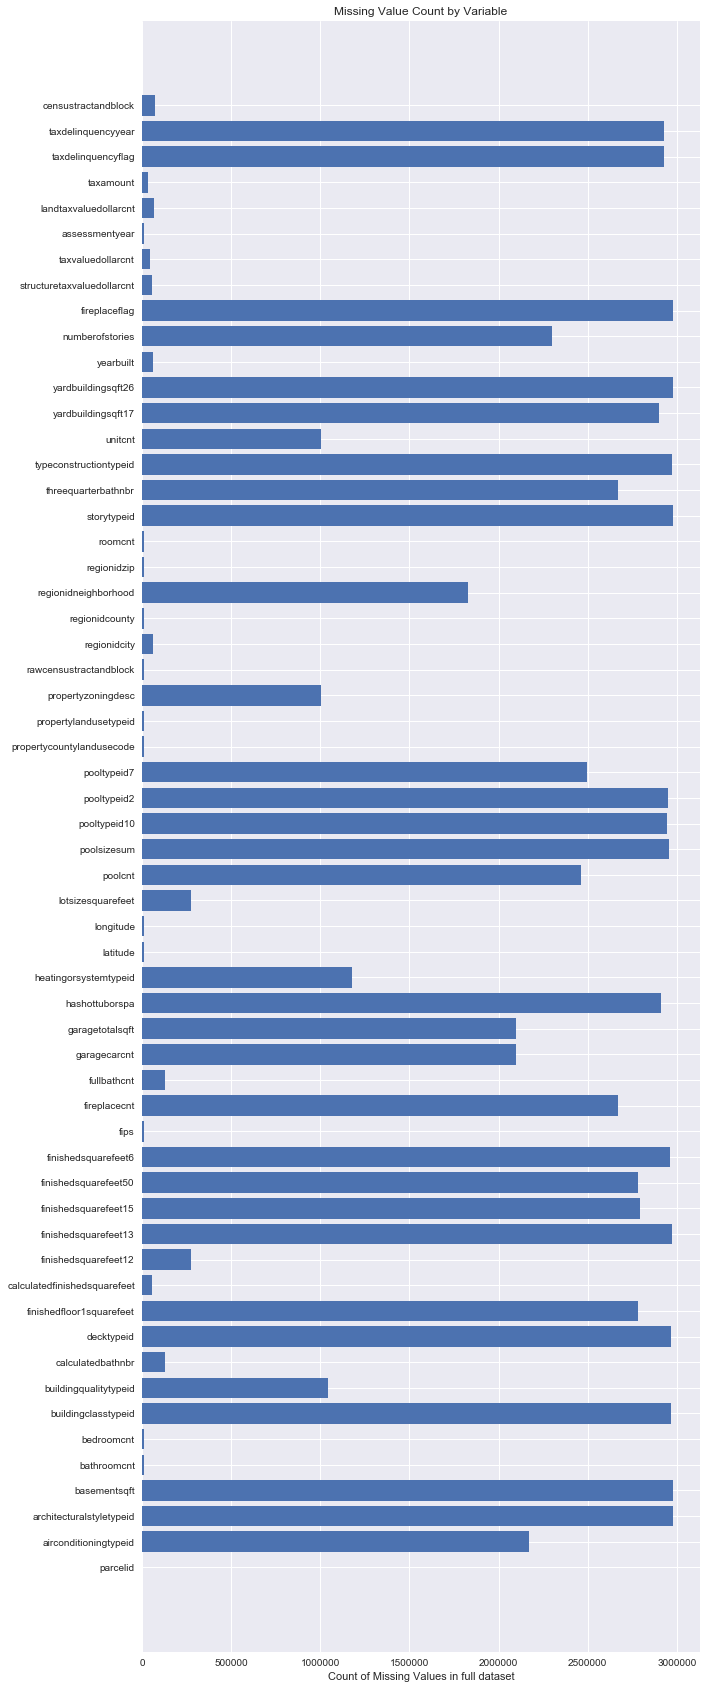

In [22]:
# Make a plot of the number of NA's for each variable
na_count = properties.isnull().sum(axis=0)
y_pos = np.arange(len(properties.columns.values.tolist()))
plt.figure(figsize=(10,30))
plt.barh( bottom = y_pos, width = na_count.values )
plt.yticks(y_pos, properties.columns.values.tolist())
plt.xlabel("Count of Missing Values in full dataset")
plt.title("Missing Value Count by Variable")
plt.show()

# From Plot (comment to add or remove from list):
low_info_columns = ['airconditioningtypeid', 
                      'architecturalstyletypeid', 
                      'basementsqft', 
#                       'bathroomcnt', 
#                       'bedroomcnt', 
                      'buildingclasstypeid', 
                      'buildingqualitytypeid', 
#                       'calculatedbathnbr', 
                      'decktypeid', 
                      'finishedfloor1squarefeet', 
#                       'calculatedfinishedsquarefeet',
#                       'finishedsquarefeet12',
                      'finishedsquarefeet13',
                      'finishedsquarefeet15', 
                      'finishedsquarefeet50', 
                      'finishedsquarefeet6', 
#                       'fips', 
                      'fireplacecnt', 
#                       'fullbathcnt', 
                      'garagecarcnt', 
                      'garagetotalsqft', 
                      'hashottuborspa',
                      'heatingorsystemtypeid', 
#                       'latitude',
#                       'longitude',
                      'lotsizesquarefeet',
                      'poolcnt',
                      'poolsizesum',
                      'pooltypeid10',
                      'pooltypeid2',
                      'pooltypeid7',
#                       'propertycountylandusecode',
#                       'propertylandusetypeid',
                      'propertyzoningdesc', 
#                       'rawcensustractandblock', 
#                       'regionidcity',
#                       'regionidcounty', 
                      'regionidneighborhood', 
#                       'regionidzip', 
#                       'roomcnt',
                      'storytypeid',
                      'threequarterbathnbr',
                      'typeconstructiontypeid',
                      'unitcnt',
                      'yardbuildingsqft17',
                      'yardbuildingsqft26',
#                       'yearbuilt',
                      'numberofstories',
#                       'structuretaxvaluedollarcnt',
#                       'taxvaluedollarcnt',
#                       'assessmentyear',
#                       'landtaxvaluedollarcnt',
#                       'taxamount',
                      'taxdelinquencyyear']
#                       'censustractandblock']



### Check if the low information columns are strongly correlated with any other column

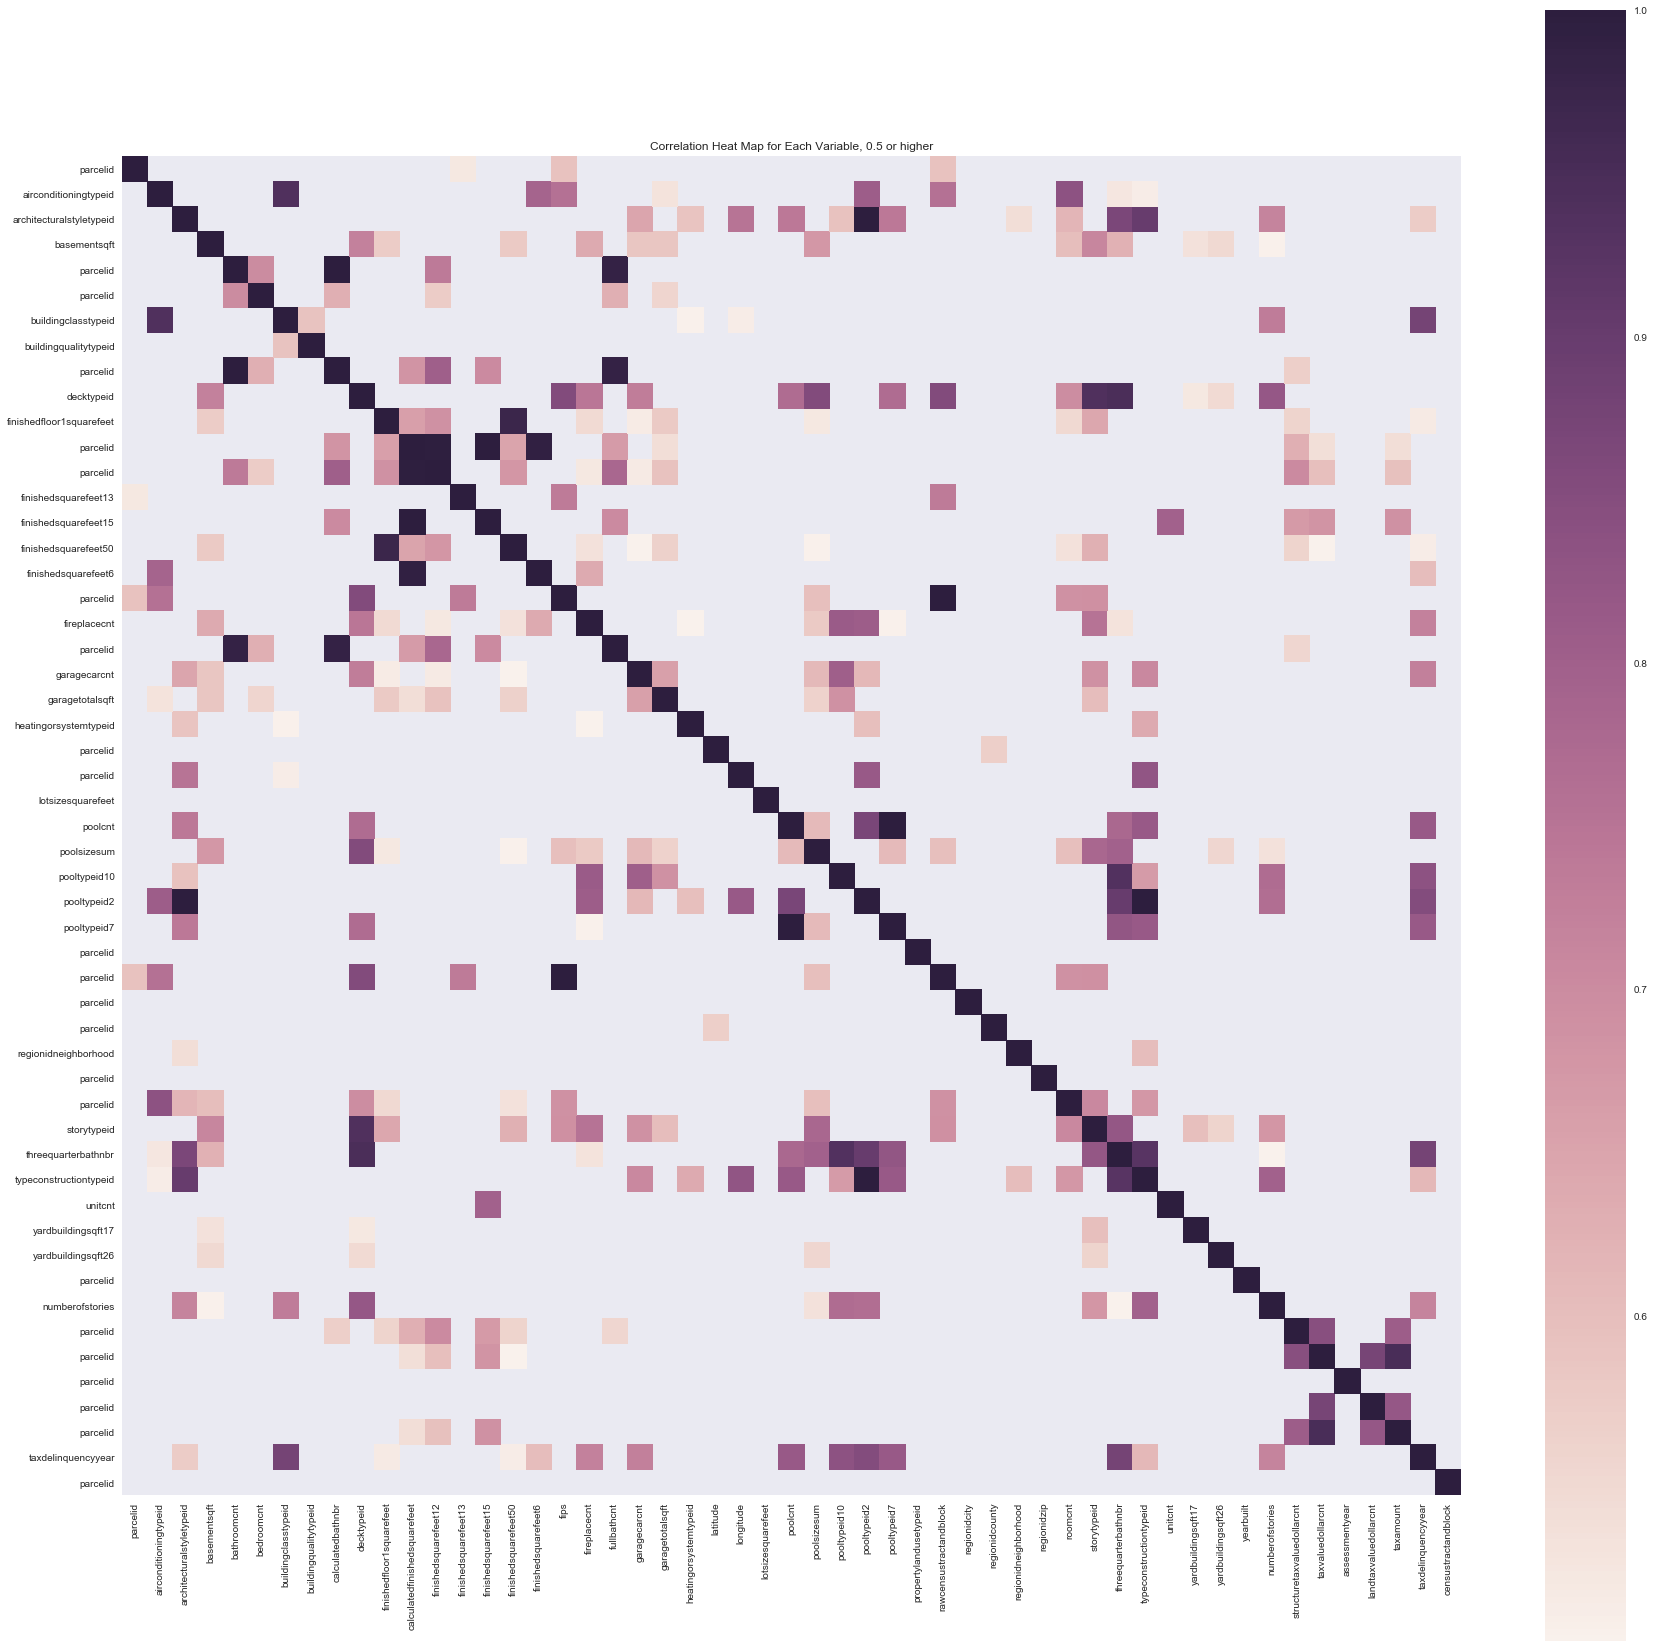

In [23]:
# Plot Heatmap ( And only show correlations higher than 0.5)
corr = properties.corr()

# Want to show only Low Information variables on the Y axis. Leave 'parcelid' as the default for a False return
low_info_index = [(x in low_info_columns)*i for i,x in enumerate(corr.columns.values)]
plt.figure(figsize=(30,30))
plt.title("Correlation Heat Map for Each Variable, 0.5 or higher")
sns.heatmap( corr[corr > 0.5], xticklabels = corr.columns.values, yticklabels = corr.columns.values[low_info_index], square=True) 

### Select variables that are strongly correlated with those features with low information

In [24]:
# Go through the correlation matrix manually to grab the variables which are strongly correlated with each low information variable

# Filter to those low information variables with a correlation of above 0.5 to any other variable 
low_info_columns_no_strings = np.array(low_info_columns)

# Create index for low info columns (and exclude strings)
low_info_columns_no_strings_index = []
for i,x in enumerate(low_info_columns):
    if x in ['hashottuborspa', 'propertyzoningdesc']:
        continue
    else:
        low_info_columns_no_strings_index.append(i)
low_info_columns_no_strings = low_info_columns_no_strings[low_info_columns_no_strings_index]

# Show Matrix (slice 5 at a time to view specific columns)
print(np.transpose(corr[low_info_columns_no_strings][corr > 0.5]))




                          parcelid  airconditioningtypeid  \
airconditioningtypeid          NaN               1.000000   
architecturalstyletypeid       NaN                    NaN   
basementsqft                   NaN                    NaN   
buildingclasstypeid            NaN               0.939458   
buildingqualitytypeid          NaN                    NaN   
decktypeid                     NaN                    NaN   
finishedfloor1squarefeet       NaN                    NaN   
finishedsquarefeet13      0.519691                    NaN   
finishedsquarefeet15           NaN                    NaN   
finishedsquarefeet50           NaN                    NaN   
finishedsquarefeet6            NaN               0.789553   
fireplacecnt                   NaN                    NaN   
garagecarcnt                   NaN                    NaN   
garagetotalsqft                NaN               0.530614   
heatingorsystemtypeid          NaN                    NaN   
lotsizesquarefeet       

#### Build a dictionary for these 'helpful' variables

In [25]:
# Structure of dictionary: {LOW INFORMATION VARIABLE : [HIGHLY, CORRELATED, VARIABLES]}

helpful_variables = {'airconditioningtypeid': ['fips', 'rawcensustractandblock', 'roomcnt', 'censustractandblock'],
                     'architecturalstyletypeid': [],
                     'basementsqft': [],
                     'buildingclasstypeid': [],
                     'buildingqualitytypeid': ['garagecarcnt' ], 
                     'decktypeid': [],
                     'finishedfloor1squarefeet':['calculatedfinishedsquarefeet', 'finishedsquarefeet12',\
                                                 'finishedsquarefeet15', 'finishedsquarefeet50', 'garagetotalsqft',\
                                                 'roomcnt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount'],
                     'finishedsquarefeet13': ['calculatedfinishedsquarefeet', 'yardbuildingsqft17', 'yardbuildingsqft26'], 
                     'finishedsquarefeet15': ['calculatedbathnbr', 'finishedfloor1squarefeet', \
                                              'calculatedfinishedsquarefeet', 'finishedsquarefeet12',\
                                              'finishedsquarefeet50','fullbathcnt', 'garagecarcnt', 'poolsizesum',\
                                              'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26',\
                                              'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount'],
                     'finishedsquarefeet50': ['finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',\
                                              'finishedsquarefeet12', 'finishedsquarefeet15', 'garagetotalsqft',\
                                              'taxvaluedollarcnt', 'taxamount'],
                     'finishedsquarefeet6': ['calculatedfinishedsquarefeet'],
                     'fireplacecnt': ['calculatedfinishedsquarefeet', 'finishedsquarefeet12'],
                     'garagecarcnt': ['bathroomcnt', 'buildingqualitytypeid', 'finishedsquarefeet12',\
                                      'finishedsquarefeet15', 'garagetotalsqft'],
                     'garagetotalsqft': ['bedroomcnt', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',\
                                         'finishedsquarefeet12', 'finishedsquarefeet50', 'garagecarcnt'],
                     'heatingorsystemtypeid': ['fips'],
                     'lotsizesquarefeet': [],
                     'poolcnt': [],
                     'poolsizesum': ['finishedsquarefeet15'],
                     'pooltypeid10': [],
                     'pooltypeid2': [],
                     'pooltypeid7': [],
                     'regionidneighborhood': [],
                     'storytypeid': [], 
                     'threequarterbathnbr': [],
                     'typeconstructiontypeid': [], 
                     'unitcnt': ['finishedsquarefeet15'],
                     'yardbuildingsqft17': ['finishedsquarefeet13', 'finishedsquarefeet15'],
                     'yardbuildingsqft26': ['finishedsquarefeet13', 'finishedsquarefeet15'],
                     'numberofstories': [],
                     'taxdelinquencyyear': []
                    }



### Use KNN to impute missing values using highly correlated variables

In [26]:
def get_onehot_indices(original_indices):
    ''' 
    Function to select the indices in the preprocessed dataframe (after one-hot encoding)
    that correspond to the original variable index.
    '''
    
    matching_onehot_features = []
    non_matching_onehot_features = []

    for i,x in enumerate(enc2.active_features_):
        for j in original_indices:
            if x >= enc2.feature_indices_[j] and x < enc2.feature_indices_[j+1]:
                matching_onehot_features.append(i)
            else:
                non_matching_onehot_features.append(i)
                
    return(matching_onehot_features, non_matching_onehot_features)

In [27]:
def knn_impute_w_onehot_variables(dataset, target_variable_list, helpful_variable_list):
    ''' 
    Function to impute values for a list of target variables (in the preprocessed dataframe) using only 
    the columns of variables highly correlated with it.
    '''
    
    target_variable = target_variable_list[0]
    
    # Copy all_data_properties table and Null out non-helpful columns (but keep in because we need them to one-hot-encode properly)
    # Preprocessing Steps prior to one-hot-encoding (to get original indices minus removed columns)
    all_data_properties_temp = all_data_properties
    all_data_properties_temp = all_data_properties_temp.select_dtypes(exclude=[object]) 
    all_data_properties_temp.fillna(-1,inplace=True)
    all_data_properties_temp.replace(replacement_dictionary, inplace=True)
      
    # Reference lists with both variable names and indices of those variables
    variable_names_temp = all_data_properties_temp.columns.values.tolist()
    boolean_catlabels_temp = [x in cat_variable_names for x in variable_names]
    boolean_inverse_catlabels_temp = [not i for i in boolean_catlabels]
    
    category_labels_index_temp = []
    for i,j in enumerate(boolean_catlabels_temp):
        if j == True:
            category_labels_index_temp.append(i)    
    
    non_category_labels_index_temp = [] 
    for i,j in enumerate(boolean_catlabels_temp):
        if j == False:
            non_category_labels_index_temp.append(i)
            
    non_cat_variable_names = [str(variable_names[i]) for i in non_category_labels_index]

    # Identify Indices of data points we have information for
    known_indices = [i for i,x in enumerate(all_data_properties_temp[target_variable].values) if x != -1 and x != 9999]
    unknown_indices = [i for i,x in enumerate(all_data_properties_temp[target_variable].values) if x == -1 or x == 9999]
    column_indices = [i for i,x in enumerate(cat_variable_names) if x in helpful_variable_list]
    target_index = [i for i,x in enumerate(cat_variable_names) if x in [target_variable]]

    # Calculate categorical indices in the onehot encoded df from original categorical indices
    column_onehot_indices, null_column_onehot_indices = get_onehot_indices(column_indices)
    target_onehot_indices, null_target_onehot_indices = get_onehot_indices(target_index)

    #Add original numerical variables to indices
    for each in non_category_labels_index_temp:
        column_onehot_indices.append(each)
    for each in non_category_labels_index_temp:
        target_onehot_indices.append(each)

    # Set KNN Training Data (existing data)
    knn_impute_x = dataset[np.ix_(known_indices,column_onehot_indices)]

    # Decide on Regression or Classification for each variable (choice of Decision Tree algorithm was for speed, mostly. Originally was KNN, hence the variable names)
    if target_variable in non_cat_variable_names:
        knn_impute = DecisionTreeRegressor()
    else:
        knn_impute = DecisionTreeClassifier()

    # Start the fun
    print("One-Hot encoded indices related to %s: \n" %(target_variable),target_onehot_indices)
    print("# of populated rows for target variable: %i \t # Unpopulated Rows: %i" %(len(known_indices), len(unknown_indices)))
    print("Fitting kNN for %s using: " %(target_variable), helpful_variable_list)
    
    for onehot_target in target_onehot_indices:
        try:
            # Set Training Labels (existing data)
            knn_impute_y = dataset[np.ix_(known_indices,[onehot_target])]

            # Set Test Data (missing data)
            knn_impute_new_data = dataset[np.ix_(unknown_indices,column_onehot_indices)]

            # Fit KNN model
            knn_impute.fit(knn_impute_x, knn_impute_y)

            # Impute missing data by using KNN prediction
            start = time.time()
            print("Predicting missing data for %s, one-hot index %i" %(target_variable, onehot_target))
            predictions = knn_impute.predict(knn_impute_new_data)
            predictions = np.reshape(np.array(predictions),(predictions.shape[0],1))
            dataset[np.ix_(unknown_indices,[onehot_target])] = predictions
            print("Finished. Elapsed Time: %0.1f minutes" %((time.time()-start)/60))
        except:
            continue
#         break ## REMOVE WHEN WE WANT TO RUN THROUGH ALL MISSING COLUMNS





### Run Decision Tree impute on all low information variables

In [28]:
for key,variables in helpful_variables.items():
    # variables to impute on
#     if variable in ['airconditioningtypeid', 
    if key in ['architecturalstyletypeid', 
                      'basementsqft', 
                      'bathroomcnt', 
                      'bedroomcnt', 
                      'buildingclasstypeid', 
                      'buildingqualitytypeid', 
                      'calculatedbathnbr', 
#                       'decktypeid', 
                      'finishedfloor1squarefeet', 
                      'calculatedfinishedsquarefeet',
                      'finishedsquarefeet12',
                      'finishedsquarefeet13',
                      'finishedsquarefeet15', 
                      'finishedsquarefeet50', 
                      'finishedsquarefeet6', 
#                       'fips', 
#                       'fireplacecnt', 
                      'fullbathcnt', 
                      'garagecarcnt', 
                      'garagetotalsqft', 
#                       'hashottuborspa', #STRING
                      'heatingorsystemtypeid', 
                      'latitude',
                      'longitude',
                      'lotsizesquarefeet',
#                       'poolcnt',
#                       'poolsizesum',
#                       'pooltypeid10',
#                       'pooltypeid2',
#                       'pooltypeid7',
#                       'propertycountylandusecode', #STRING
                      'propertylandusetypeid',
#                       'propertyzoningdesc', #STRING
                      'rawcensustractandblock', 
                      'regionidcity', # Keep as categorical
                      'regionidcounty', # Keep as categorical
                      'regionidneighborhood', # Keep as categorical
                      'regionidzip', # Keep as categorical
                      'roomcnt',
                      'storytypeid',
                      'threequarterbathnbr',
#                       'typeconstructiontypeid',
#                       'unitcnt',
                      'yardbuildingsqft17',
                      'yardbuildingsqft26',
                      'yearbuilt',
                      'numberofstories',
#                       'fireplaceflag', #STRING
                      'structuretaxvaluedollarcnt',
                      'taxvaluedollarcnt',
                      'assessmentyear',
                      'landtaxvaluedollarcnt',
                      'taxamount',
#                       'taxdelinquencyflag', #STRING
#                       'taxdelinquencyyear',
                    'censustractandblock']:
        knn_impute_w_onehot_variables(all_data_properties2, [key], variables)
#         break ## REMOVE WHEN WE WANT TO RUN THROUGH ALL MISSING COLUMNS
    else:
        continue




C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3855: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


One-Hot encoded indices related to architecturalstyletypeid: 
 [7, 8, 9, 10, 11, 12, 13, 2, 9, 10, 11, 12, 13, 14, 15, 20, 21, 23, 24, 25, 27, 31, 33, 44, 45, 48, 49, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
# of populated rows for target variable: 261 	 # Unpopulated Rows: 90014
Fitting kNN for architecturalstyletypeid using:  []
Predicting missing data for architecturalstyletypeid, one-hot index 7
Finished. Elapsed Time: 0.0 minutes
Predicting missing data for architecturalstyletypeid, one-hot index 8
Finished. Elapsed Time: 0.0 minutes
Predicting missing data for architecturalstyletypeid, one-hot index 9
Finished. Elapsed Time: 0.0 minutes
Predicting missing data for architecturalstyletypeid, one-hot index 10
Finished. Elapsed Time: 0.0 minutes
Predicting missing data for architecturalstyletypeid, one-hot index 11
Finished. Elapsed Time: 0.0 minutes
Predicting missing data for architecturalstyletypeid, one-hot index 12
Finished. Elapsed Time: 0.0 minut

In general, this seemed like a reasonable approach to imputing missing data following the onehot encoding step, though predicting whether a house is in a specific neighborhood for instance and then doing that for every neighborhood could result in multiple neighborhoods picked for one data point. This could be viewed as a bit of an averaging of the likelihood that a home is in multiple neighborhoods (sort of like a GMM?) but probably isn't the most computationally efficient or elegant way to go about doing this.  

### Center and Scale all Variables

In [29]:
# Center and Scale Numerical Variables
scale2 = StandardScaler(with_mean = True)
all_data_properties2 = scale2.fit_transform(all_data_properties2)

print("Shape of All Data:",all_data_properties2.shape)

Shape of All Data: (90275, 1910)


# Model Building

### Split out a Train and Test Set

In [16]:
# Calculate an index to split at (80% train/test split)
split_index = int(round(all_data.shape[0] * 0.8))

# Split into Train and Test Sets (already shuffled)
train_data = all_data_properties[:split_index] # Not Preprocessed at all
test_data = all_data_properties[split_index:] # Not Preprocessed at all
train_data1 = all_data_properties1[:split_index]
test_data1 = all_data_properties1[split_index:]
train_data2 = all_data_properties2[:split_index]
test_data2 = all_data_properties2[split_index:]
train_labels = all_data_labels[:split_index]
test_labels =  all_data_labels[split_index:]

print("Shape of Training Data:", train_data1.shape)
print("Shape of Test Data:", test_data1.shape)

Shape of Training Data: (72220, 2136)
Shape of Test Data: (18055, 2136)


### Fit a few Single Models for Train1

In [17]:
# Single Fit of a Linear Regressor
start = time.time()
reg = LinearRegression()
reg.fit(train_data1, train_labels)
reg_pred = reg.predict(test_data1)
print("Linear Regressor \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, reg_pred),(time.time()-start)/60))

# Single Fit of a Ridge Regressor
start = time.time()
ridge = Ridge(alpha = 0.8)
ridge.fit(train_data1, train_labels)
ridge_pred = ridge.predict(test_data1)
print("Ridge Regression \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, ridge_pred),(time.time()-start)/60))

# Single Fit of a Decision Tree Regressor
start = time.time()
dt = DecisionTreeRegressor(criterion = 'mae', max_features = 10, max_depth = 4)
dt.fit(train_data1, train_labels)
dt_pred = dt.predict(test_data1)
print("Decision Tree Regressor \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, dt_pred),(time.time()-start)/60))

# # Single Fit of a KNN Regressor
# start = time.time()
# knn = KNeighborsRegressor(n_neighbors = 100)
# knn.fit(train_data1, train_labels)
# knn_pred = knn.predict(test_data1)
# print("KNN Regressor \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, knn_pred),(time.time()-start)/60))

# # Single Fit of a Random Forests Regressor
# start = time.time()
# rf = RandomForestRegressor(n_estimators=10)
# rf.fit(train_data1, train_labels)
# rf_pred = rf.predict(test_data1)
# print("Random Forests Regressor \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, rf_pred),(time.time()-start)/60))

# Single Fit of a SVM Regressor
start = time.time()
svr = LinearSVR(epsilon=0.0, tol=0.0001, C=0.8)
svr.fit(train_data1, train_labels)
svr_pred = svr.predict(test_data1)
print("SVM Regressor \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, svr_pred),(time.time()-start)/60))

# Single Fit of an Adaboost Regressor
start = time.time()
ada = AdaBoostRegressor(n_estimators=50)
ada.fit(train_data1, train_labels)
ada_pred = ada.predict(test_data1)
print("Adaboost Regressor \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, ada_pred),(time.time()-start)/60))

# Single Fit of a LightGBM Regressor
d_train = lgb.Dataset(train_data1, label=train_labels, free_raw_data=False)
d_test = lgb.Dataset(test_data1, label=test_labels, free_raw_data=False)

params = {}
params['learning_rate'] = 0.002
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['feature_fraction'] = 0.5
params['num_leaves'] = 60
params['min_data_in_leaf'] = 500
params['min_hessian'] = 1
params['lambda_l2'] = 1
params['verbosity'] = -1

start = time.time()
watchlist = [d_test]
GBM = lgb.train(params, d_train, 500, watchlist)

GBM.reset_parameter({"num_threads":1})
GBM_pred = GBM.predict(test_data1)
# Show Negative Mean Absolute Error
print("LightGBM Regressor \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, GBM_pred),(time.time()-start)/60))


Linear Regressor 		 Neg Mean Absolute Error: -6422835.68534 	 Runtime: 0.4 minutes
Ridge Regression 		 Neg Mean Absolute Error: -0.07261 	 Runtime: 0.1 minutes
Decision Tree Regressor 	 Neg Mean Absolute Error: -0.06855 	 Runtime: 1.3 minutes
SVM Regressor 		 Neg Mean Absolute Error: -0.07023 	 Runtime: 0.3 minutes
Adaboost Regressor 		 Neg Mean Absolute Error: -0.16444 	 Runtime: 4.4 minutes
[1]	valid_0's l1: 0.068814
[2]	valid_0's l1: 0.0688114
[3]	valid_0's l1: 0.0688081
[4]	valid_0's l1: 0.068807
[5]	valid_0's l1: 0.0688058
[6]	valid_0's l1: 0.068804
[7]	valid_0's l1: 0.068803
[8]	valid_0's l1: 0.0688008
[9]	valid_0's l1: 0.0687974
[10]	valid_0's l1: 0.0687966
[11]	valid_0's l1: 0.0687948
[12]	valid_0's l1: 0.0687913
[13]	valid_0's l1: 0.0687902
[14]	valid_0's l1: 0.0687872
[15]	valid_0's l1: 0.0687842
[16]	valid_0's l1: 0.0687822
[17]	valid_0's l1: 0.0687801
[18]	valid_0's l1: 0.0687767
[19]	valid_0's l1: 0.0687748
[20]	valid_0's l1: 0.0687734
[21]	valid_0's l1: 0.0687716
[22]	val

### Fit a few Single Models for Train2

In [32]:
# Single Fit of a Linear Regressor
start = time.time()
reg2 = LinearRegression()
reg2.fit(train_data2, train_labels)
reg2_pred = reg2.predict(test_data2)
print("Linear Regressor \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, reg2_pred),(time.time()-start)/60))

# Single Fit of a Ridge Regressor
start = time.time()
ridge2 = Ridge(alpha = 0.8)
ridge2.fit(train_data2, train_labels)
ridge2_pred = ridge2.predict(test_data2)
print("Ridge Regression \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, ridge2_pred),(time.time()-start)/60))

# Single Fit of a Decision Tree Regressor
start = time.time()
dt2 = DecisionTreeRegressor(criterion = 'mae', max_features = 10, max_depth = 4)
dt2.fit(train_data2, train_labels)
dt2_pred = dt2.predict(test_data2)
print("Decision Tree Regressor \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, dt2_pred),(time.time()-start)/60))

# # Single Fit of a KNN Regressor
# start = time.time()
# knn2 = KNeighborsRegressor(n_neighbors = 100)
# knn2.fit(train_data2, train_labels)
# knn2_pred = knn2.predict(test_data2)
# print("KNN Regressor \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, knn2_pred),(time.time()-start)/60))

# # Single Fit of a Random Forests Regressor
# start = time.time()
# rf2 = RandomForestRegressor(n_estimators=10)
# rf2.fit(train_data2, train_labels)
# rf2_pred = rf2.predict(test_data2)
# print("Random Forests Regressor \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, rf2_pred),(time.time()-start)/60))

# Single Fit of a SVM Regressor
start = time.time()
svr2 = LinearSVR(epsilon=0.0, tol=0.0001, C=0.8)
svr2.fit(train_data2, train_labels)
svr2_pred = svr2.predict(test_data2)
print("SVM Regressor \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, svr2_pred),(time.time()-start)/60))

# Single Fit of an Adaboost Regressor
start = time.time()
ada2 = AdaBoostRegressor(n_estimators=50)
ada2.fit(train_data2, train_labels)
ada2_pred = ada2.predict(test_data2)
print("Adaboost Regressor \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, ada2_pred),(time.time()-start)/60))

# Single Fit of a LightGBM Regressor
d_train2 = lgb.Dataset(train_data2, label=train_labels, free_raw_data=False)
d_test2 = lgb.Dataset(test_data2, label=test_labels, free_raw_data=False)

params = {}
params['learning_rate'] = 0.002
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['feature_fraction'] = 0.5
params['num_leaves'] = 60
params['min_data_in_leaf'] = 500
params['min_hessian'] = 1
params['lambda_l2'] = 1
params['verbosity'] = -1

start = time.time()
watchlist = [d_test2]
GBM2 = lgb.train(params, d_train, 500, watchlist)

GBM2.reset_parameter({"num_threads":1})
GBM2_pred = GBM2.predict(test_data2)
# Show Negative Mean Absolute Error
print("LightGBM Regressor \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, GBM2_pred),(time.time()-start)/60))


Linear Regressor 	 Neg Mean Absolute Error: -28777053515.09999 	 Runtime: 0.3 minutes
Ridge Regression 	 Neg Mean Absolute Error: -0.07202 	 Runtime: 0.1 minutes
Decision Tree Regressor 	 Neg Mean Absolute Error: -0.06777 	 Runtime: 1.4 minutes
SVM Regressor 	 Neg Mean Absolute Error: -0.12188 	 Runtime: 4.6 minutes
Adaboost Regressor 	 Neg Mean Absolute Error: -0.22331 	 Runtime: 4.1 minutes
[1]	valid_0's l1: 0.0681354
[2]	valid_0's l1: 0.06813
[3]	valid_0's l1: 0.0681299
[4]	valid_0's l1: 0.0681307
[5]	valid_0's l1: 0.0681283
[6]	valid_0's l1: 0.0681335
[7]	valid_0's l1: 0.0681292
[8]	valid_0's l1: 0.0681257
[9]	valid_0's l1: 0.0681265
[10]	valid_0's l1: 0.0681215
[11]	valid_0's l1: 0.0681192
[12]	valid_0's l1: 0.0681211
[13]	valid_0's l1: 0.0681207
[14]	valid_0's l1: 0.0681217
[15]	valid_0's l1: 0.068122
[16]	valid_0's l1: 0.0681226
[17]	valid_0's l1: 0.0681193
[18]	valid_0's l1: 0.0681193
[19]	valid_0's l1: 0.0681239
[20]	valid_0's l1: 0.0681235
[21]	valid_0's l1: 0.0681225
[22]	va

## Comparison of Preprocessing Paths & Models

In [33]:
# Exclude those we don't want to plot

# cols = ["PP1, Linear", 
cols = ["PP1, Ridge(0.8)", 
        "PP1, Decision Tree(10,4)", 
#         "PP1, KNN(100)", 
#         "PP1, RF(10)", 
        "PP1, SVM(0.8)", 
        "PP1, Adaboost(50)", 
        "PP1, LightGBM",
#         "PP2, Linear", 
        "PP2, Ridge(0.8)", 
        "PP2, Decision Tree(10,4)", 
#         "PP2, KNN(100)", 
#         "PP2, RF(10)", 
        "PP2, SVM(0.8)", 
        "PP2, Adaboost(50)", 
        "PP2, LightGBM"]
# results = [-metrics.mean_absolute_error(test_labels, reg_pred),
results = [-metrics.mean_absolute_error(test_labels, ridge_pred),
          -metrics.mean_absolute_error(test_labels, dt_pred),
#           -metrics.mean_absolute_error(test_labels, knn_pred),
#           -metrics.mean_absolute_error(test_labels, rf_pred),
          -metrics.mean_absolute_error(test_labels, svr_pred),
          -metrics.mean_absolute_error(test_labels, ada_pred),
          -metrics.mean_absolute_error(test_labels, GBM_pred),
#           -metrics.mean_absolute_error(test_labels, reg2_pred),
          -metrics.mean_absolute_error(test_labels, ridge2_pred),
          -metrics.mean_absolute_error(test_labels, dt2_pred),
#           -metrics.mean_absolute_error(test_labels, knn2_pred),
#           -metrics.mean_absolute_error(test_labels, rf2_pred),
          -metrics.mean_absolute_error(test_labels, svr2_pred),
          -metrics.mean_absolute_error(test_labels, ada2_pred),
          -metrics.mean_absolute_error(test_labels, GBM2_pred)
          ]

comparison = np.array(results)



### Plot to compare each model

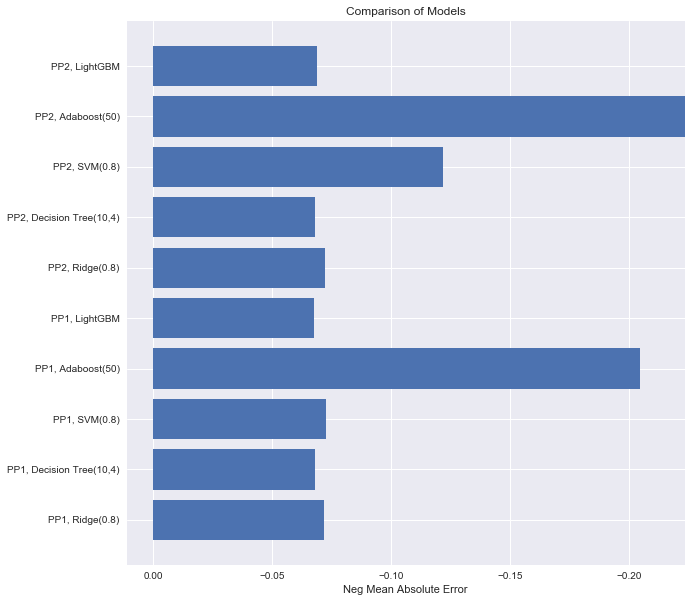

In [34]:
y_pos = np.arange(len(comparison))
plt.figure(figsize=(10,10))
plt.barh( bottom = y_pos, width = comparison )
# plt.barh( bottom = y_pos, width = comparison.values )
plt.yticks(y_pos, cols)
plt.gca().invert_xaxis()
plt.xlabel("Neg Mean Absolute Error")
plt.title("Comparison of Models")
plt.show()


### Plot importance of each variable with lightGBM Calculations (tough to interpret after encoding)

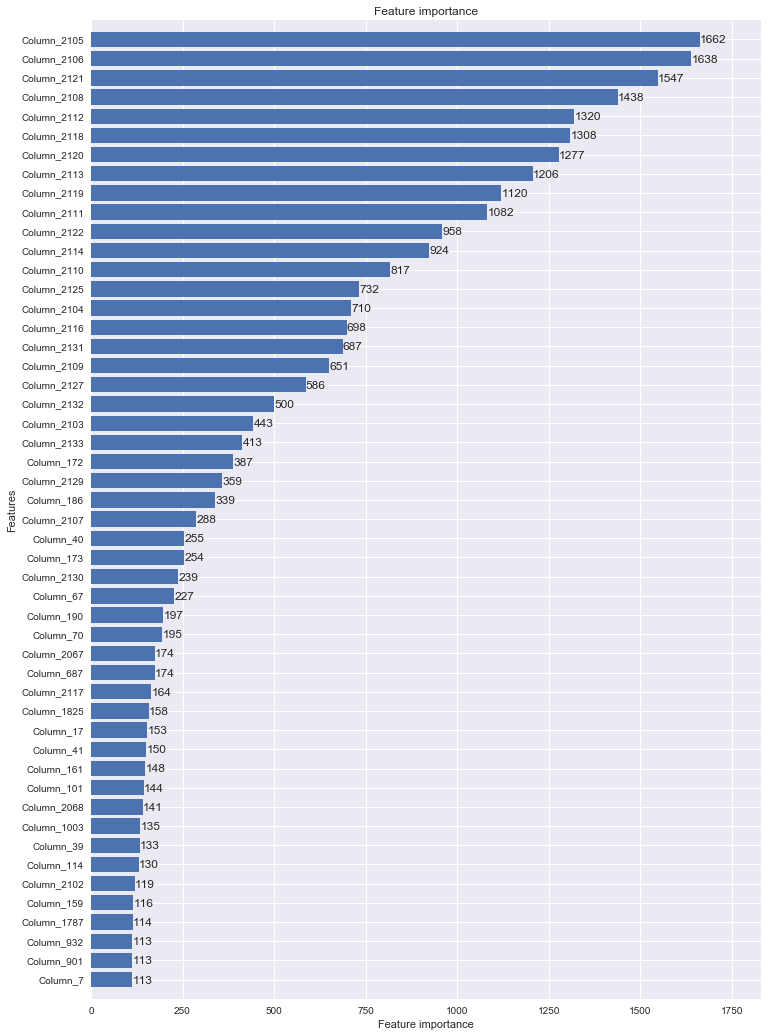

In [35]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(GBM, max_num_features=50, height=0.8, ax=ax)
# ax.set_yticklabels(x)
# Didn't have time to back calculate the original variable name for each of these one-hot variables
plt.show()

# Run PCA on Train1

In [36]:
# Vary number of PCA components to see % variance 
print(train_data1.shape, test_data1.shape)

# Convert these lists to numpy arrays.
train_data1_np = np.array(train_data1)
test_data1_np = np.array(test_data1)

k = range(0,1000,20)

pca = PCA(n_components=5, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
pca.fit(test_data1_np)
print(pca.explained_variance_ratio_)
print("Fraction of Total Variance explained by first %i principal components: %0.2f%%" %(1, sum(pca.explained_variance_ratio_)*100))

pca_results = []
for each in k:
    pca = PCA(n_components=each, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
    pca.fit(test_data1_np)
    pca_results.append([each, sum(pca.explained_variance_ratio_)*100])
    print("Fraction of Total Variance explained by first %i principal components: %0.2f%%" %(each, sum(pca.explained_variance_ratio_)*100))




(72220, 2136) (18055, 2136)
[ 0.11661185  0.0898876   0.08493758  0.06359433  0.04820633]
Fraction of Total Variance explained by first 1 principal components: 40.32%
Fraction of Total Variance explained by first 0 principal components: 0.00%
Fraction of Total Variance explained by first 20 principal components: 74.91%
Fraction of Total Variance explained by first 40 principal components: 83.78%
Fraction of Total Variance explained by first 60 principal components: 86.21%
Fraction of Total Variance explained by first 80 principal components: 87.72%
Fraction of Total Variance explained by first 100 principal components: 88.94%
Fraction of Total Variance explained by first 120 principal components: 90.00%
Fraction of Total Variance explained by first 140 principal components: 90.92%
Fraction of Total Variance explained by first 160 principal components: 91.72%
Fraction of Total Variance explained by first 180 principal components: 92.42%
Fraction of Total Variance explained by first 200 

### Plot PCA Results

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\stats\smoothers.py:150: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"


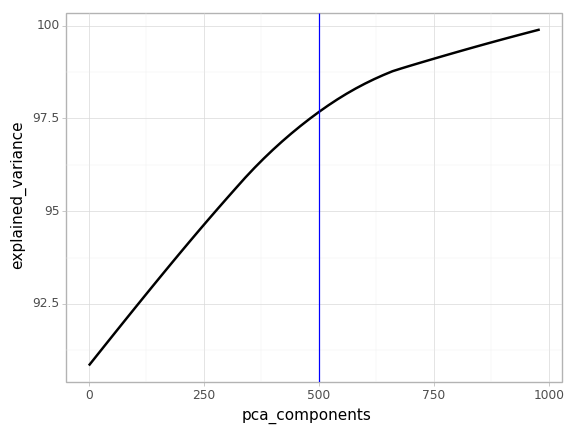

<ggplot: (142811887599)>


In [40]:
pca_results_array = np.array(pca_results)
df = {'pca_components': pca_results_array[:,0], 'explained_variance': pca_results_array[:,1]}
pca_results_df = pd.DataFrame(data=df)
print(ggplot(pca_results_df, aes(x = 'pca_components', y = 'explained_variance')) \
      + geom_smooth() \
      + geom_vline(xintercept=[500], color = 'blue') \
      + theme_light())


The slope of the variance vs pca plot suggests that a reasonable number of PCA components would be around 500. Or for cheaper runs, around 100 components is pretty solid.

### PCA Train and Transform Datasets

In [41]:
# Use 500 components for PCA
pca = PCA(n_components=500, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
pca.fit(test_data1)
print("Fraction of Total Variance explained by first %i principal components: %0.2f%%" %(500, sum(pca.explained_variance_ratio_)*100))

pca_train_data = pca.transform(train_data1)
pca_test_data = pca.transform(test_data1)


Fraction of Total Variance explained by first 500 principal components: 97.93%


## Models after PCA

In [42]:
# Single Fit of a Linear Regressor
start = time.time()
reg_pca = LinearRegression()
reg_pca.fit(pca_train_data, train_labels)
reg_pred = reg_pca.predict(pca_test_data)
print("Linear Regressor \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, reg_pred),(time.time()-start)/60))

# Single Fit of a Ridge Regressor
start = time.time()
ridge_pca = Ridge(alpha = 0.8)
ridge_pca.fit(pca_train_data, train_labels)
ridge_pred = ridge_pca.predict(pca_test_data)
print("Ridge Regression \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, ridge_pred),(time.time()-start)/60))

# Single Fit of a Decision Tree Regressor
start = time.time()
dt_pca = DecisionTreeRegressor(criterion = 'mae', max_features = 10, max_depth = 4)
dt_pca.fit(pca_train_data, train_labels)
dt_pred = dt_pca.predict(pca_test_data)
print("Decision Tree Regressor \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, dt_pred),(time.time()-start)/60))

# # Single Fit of a KNN Regressor
# start = time.time()
# knn_pca = KNeighborsRegressor(n_neighbors = 100)
# knn_pca.fit(pca_train_data, train_labels)
# knn_pred = knn_pca.predict(pca_test_data)
# print("KNN Regressor \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, knn_pred),(time.time()-start)/60))

# # Single Fit of a Random Forests Regressor
# start = time.time()
# rf_pca = RandomForestRegressor(n_estimators=10)
# rf_pca.fit(pca_train_data, train_labels)
# rf_pred = rf_pca.predict(pca_test_data)
# print("Random Forests Regressor \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, rf_pred),(time.time()-start)/60))

# Single Fit of a SVM Regressor
start = time.time()
svr_pca = LinearSVR(epsilon=0.0, tol=0.0001, C=0.8)
svr_pca.fit(pca_train_data, train_labels)
svr_pred = svr_pca.predict(pca_test_data)
print("SVM Regressor \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, svr_pred),(time.time()-start)/60))

# Single Fit of an Adaboost Regressor
start = time.time()
ada_pca = AdaBoostRegressor(n_estimators=50)
ada_pca.fit(pca_train_data, train_labels)
ada_pred = ada_pca.predict(pca_test_data)
print("Adaboost Regressor \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, ada_pred),(time.time()-start)/60))

# Single Fit of a LightGBM Regressor
d_train = lgb.Dataset(pca_train_data, label=train_labels, free_raw_data=False)
d_test = lgb.Dataset(pca_test_data, label=test_labels, free_raw_data=False)

params = {}
params['learning_rate'] = 0.002
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['feature_fraction'] = 0.5
params['num_leaves'] = 60
params['min_data_in_leaf'] = 500
params['min_hessian'] = 1
params['lambda_l2'] = 1
params['verbosity'] = -1

start = time.time()
watchlist = [d_test]
GBM_pca = lgb.train(params, d_train, 500, watchlist)

GBM_pca.reset_parameter({"num_threads":1})
GBM_pred = GBM_pca.predict(pca_test_data)
# Show Negative Mean Absolute Error
print("LightGBM Regressor \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, GBM_pred),(time.time()-start)/60))


Linear Regressor 		 Neg Mean Absolute Error: -0.06965 	 Runtime: 0.0 minutes
Ridge Regression 		 Neg Mean Absolute Error: -0.06964 	 Runtime: 0.0 minutes
Decision Tree Regressor 	 Neg Mean Absolute Error: -0.06785 	 Runtime: 4.4 minutes
SVM Regressor 		 Neg Mean Absolute Error: -0.06886 	 Runtime: 1.2 minutes
Adaboost Regressor 		 Neg Mean Absolute Error: -0.12767 	 Runtime: 4.2 minutes
[1]	valid_0's l1: 0.0681392
[2]	valid_0's l1: 0.068137
[3]	valid_0's l1: 0.0681353
[4]	valid_0's l1: 0.0681338
[5]	valid_0's l1: 0.0681324
[6]	valid_0's l1: 0.0681302
[7]	valid_0's l1: 0.0681292
[8]	valid_0's l1: 0.0681278
[9]	valid_0's l1: 0.0681257
[10]	valid_0's l1: 0.0681242
[11]	valid_0's l1: 0.0681225
[12]	valid_0's l1: 0.0681212
[13]	valid_0's l1: 0.0681197
[14]	valid_0's l1: 0.0681181
[15]	valid_0's l1: 0.0681165
[16]	valid_0's l1: 0.0681142
[17]	valid_0's l1: 0.0681131
[18]	valid_0's l1: 0.0681114
[19]	valid_0's l1: 0.0681095
[20]	valid_0's l1: 0.0681076
[21]	valid_0's l1: 0.0681058
[22]	valid_

### Multiple Fits of a LightGBM Regressor using PCA

In [ ]:
d_train = lgb.Dataset(pca_train_data, label=train_labels, free_raw_data=False)
d_test = lgb.Dataset(pca_test_data, label=test_labels, free_raw_data=False)

params = {}
params['learning_rate'] = 0.002
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['feature_fraction'] = 0.5
params['num_leaves'] = 60
params['min_data_in_leaf'] = 500
params['min_hessian'] = 1
params['lambda_l2'] = 1
params['verbosity'] = -10
# params['categorical_feature'] = 0,1,3,4,5,6,7,8,17,18,19,21,25,27,28,29,30,32,33,34,35,36,37,38,39,40,43,44,47,50

best_params = {'boosting_type': None, 'feature_fraction': 0, 'num_leaves': 0, 'score': 0}
for boosting_type in ['gbdt']:
    for frac in [0.5,0.7]:
        for leaves in range(40,120,40):
            
            params['boosting_type'] = boosting_type
            params['feature_fraction'] = frac
            params['num_leaves'] = leaves
            start = time.time()
            watchlist = [d_test]
            GBM_pca = lgb.train(params, d_train, 500, watchlist)
#             GBM.reset_parameter({"num_threads":1})
            score = -metrics.mean_absolute_error(test_labels, GBM_pca.predict(pca_test_data))
            print("Boost Type: %s \t Feature_Frac: %0.1f \t Num_Leaves: %i \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(boosting_type,frac,leaves,score,(time.time()-start)/60))
            if score < best_params['score']:
                best_params['boosting_type'] = boosting_type
                best_params['feature_fraction'] = frac
                best_params['num_leaves'] = leaves
                best_params['score'] = score

print("BEST: Boost Type: %s \t Feature_Frac: %0.1f \t Num_Leaves: %i \t Neg Mean Absolute Error: %0.5f" %(best_params['boosting_type'],best_params['feature_fraction'],best_params['num_leaves'], best_params['score']))    
    


[1]	valid_0's l1: 0.0681394
[2]	valid_0's l1: 0.0681372
[3]	valid_0's l1: 0.0681357
[4]	valid_0's l1: 0.0681343
[5]	valid_0's l1: 0.0681327
[6]	valid_0's l1: 0.0681308
[7]	valid_0's l1: 0.0681298
[8]	valid_0's l1: 0.0681284
[9]	valid_0's l1: 0.0681265
[10]	valid_0's l1: 0.0681249
[11]	valid_0's l1: 0.0681236
[12]	valid_0's l1: 0.0681224
[13]	valid_0's l1: 0.0681211
[14]	valid_0's l1: 0.0681195
[15]	valid_0's l1: 0.068118
[16]	valid_0's l1: 0.0681158
[17]	valid_0's l1: 0.0681146
[18]	valid_0's l1: 0.068113
[19]	valid_0's l1: 0.0681113
[20]	valid_0's l1: 0.0681097
[21]	valid_0's l1: 0.068108
[22]	valid_0's l1: 0.0681071
[23]	valid_0's l1: 0.0681055
[24]	valid_0's l1: 0.0681039
[25]	valid_0's l1: 0.0681023
[26]	valid_0's l1: 0.0681008
[27]	valid_0's l1: 0.068099
[28]	valid_0's l1: 0.068098
[29]	valid_0's l1: 0.0680966
[30]	valid_0's l1: 0.0680956
[31]	valid_0's l1: 0.068094
[32]	valid_0's l1: 0.0680925
[33]	valid_0's l1: 0.0680913
[34]	valid_0's l1: 0.0680902
[35]	valid_0's l1: 0.0680889


### Using a Pipeline & GridSearch - Decision Tree Regression after PCA

In [ ]:
start = time.time()

pipeline1 = Pipeline([#('onehot', OneHotEncoder(categorical_features=boolean_catlabels, sparse=False, handle_unknown = 'ignore')),
#                       ('scale', StandardScaler(with_mean=True)),
                      ('clf', DecisionTreeRegressor())])

gs_pca = GridSearchCV(pipeline1, param_grid = {'clf__criterion': ['mae'], 'clf__max_features': [10,40,100], 'clf__max_depth': [2,4]}, scoring='neg_mean_absolute_error', verbose = 1)

gs_pca.fit(pca_train_data, train_labels)

print("Runtime: %0.1f minutes" %((time.time()-start)/60))
print("Decision Tree GridSearch \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(gs_pca.best_score_,(time.time()-start)/60))
print("Best Parameters:", gs_pca.best_params_)

### Using a Pipeline & GridSearch - KNN Regression after PCA

In [ ]:
# start = time.time()

# pipeline2 = Pipeline([#('onehot', OneHotEncoder(categorical_features=boolean_catlabels, sparse=False, handle_unknown = 'ignore')),
#   #                    ('scale', StandardScaler(with_mean=True)),
#                       ('clf', KNeighborsRegressor())])

# gs2_pca = GridSearchCV(pipeline2, param_grid = {'clf__n_neighbors': [10,50,100,200,500]}, scoring='neg_mean_absolute_error', verbose = 1)

# gs2_pca.fit(pca_train_data, train_labels)

# print("Runtime: %0.1f minutes" %((time.time()-start)/60))
# print("KNN GridSearch \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(gs2_pca.best_score_,(time.time()-start)/60))
# print("Best Parameters:", gs2_pca.best_params_)

### Using a Pipeline & GridSearch - SVR Regression after PCA

In [ ]:
# start = time.time()

# pipeline3 = Pipeline([#('onehot', OneHotEncoder(categorical_features=boolean_catlabels, sparse=False, handle_unknown = 'ignore')),
#  #                     ('scale', StandardScaler(with_mean=True)),
#                       ('clf', LinearSVR())])

# gs3_pca = GridSearchCV(pipeline3, param_grid = {'clf__C': [0.1,0.3,0.5,0.7,0.9,1]}, scoring='neg_mean_absolute_error', verbose = 1)

# gs3_pca.fit(pca_train_data, train_labels)

# print("Runtime: %0.1f minutes" %((time.time()-start)/60))
# print("SVR GridSearch \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(gs3_pca.best_score_,(time.time()-start)/60))
# print("Best Parameters:", gs3_pca.best_params_)


# Working with Conditional KNN and Original Data

### GET DATA AND EXPLORE

In [32]:
import pandas as pd
import numpy as np

chunk_size = 10**5
df = pd.concat([chunk for chunk in pd.read_csv(r"./Data/properties_2016.csv", low_memory=False, chunksize=chunk_size)],
               ignore_index=False)

len(list(df))

list(df)
train_labels = pd.concat([chunk for chunk in pd.read_csv(r"./Data/train_2016_v2.csv", low_memory=False, chunksize=chunk_size)],
               ignore_index=False)

list(train_labels)

ids = train_labels["parcelid"]
train_labels[ids.isin(ids[ids.duplicated()])]

train_labels.shape


train_data = pd.DataFrame(index = range(len(train_labels['parcelid'])),columns = list(df))

train_data = train_labels.merge(df, how='left', on='parcelid')

print(train_data['parcelid'][100], train_labels['parcelid'][100])

14322594 14322594


### IDENTIFYING DUPLICATES IN LABELS

In [33]:
keys = ['parcelid']
i1 = train_data.set_index(keys).index
i2 = train_labels.set_index(keys).index
train_data[i1.isin(i2)].shape

ids[ids.duplicated()].shape
train_data['parcelid'][[1000]] == train_labels['parcelid'][[1000]]

1000    True
Name: parcelid, dtype: bool

In [34]:
# create a date array from the string array
print(train_labels['logerror'][3])
print(train_labels['transactiondate'][100])
x = []

from dateutil import parser
for i in range(len(train_labels['transactiondate'])):
    x.append(parser.parse(train_labels['transactiondate'][i]))

0.0218
2016-01-04


###  DOES SALES DATE MATTER ?

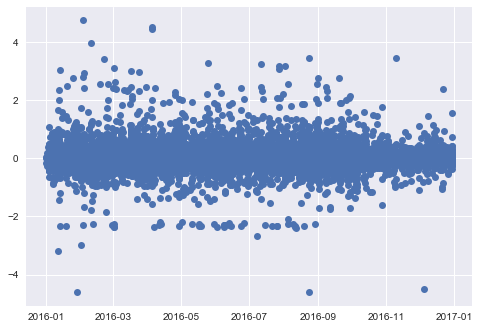

In [35]:
#exploratory plot of train_labels
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np


y = np.zeros(len(train_labels['logerror']))
y = train_labels['logerror']

fig1 = plt.figure()
plt.plot_date(x, y)
#y = train_labels['transactiondate']



#plt.plot(x, y)
plt.show()


In [36]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm


x_train = train_data.drop(['parcelid', 'logerror'], axis=1)



In [37]:
from sklearn.preprocessing import LabelEncoder
train_data

num_quant = 5
#train_data['quantile'] = pd.qcut(train_data['logerror'], num_quant, labels=False)
#train_data['quantile']
g = x_train.columns.to_series().groupby(x_train.dtypes).groups
g 
print(len(train_data.columns[train_data.isnull().any()]))

for c in x_train.columns:
    x_train[c]=x_train[c].fillna(-1000)
    if x_train[c].dtype == 'object':
     
        lbl = LabelEncoder()
        lbl.fit(list(x_train[c].values))
        train_data[c] = lbl.transform(list(x_train[c].values))

print(len(x_train.columns[x_train.isnull().any()]))    
print(g)

print(x_train.shape)
print(train_labels.shape)
y_labels = train_labels['logerror']
print(y_labels.shape)

47
0
{dtype('float64'): Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'structuretaxva

### RUN CODE FOR EACH ZIPCODE (EXPLORATORY)

In [38]:
#############  K Nearest Neighbors Regressor ############
start = time.time()
knn_train_data = x_train[:70000] 
knn_test_data = x_train[70000:]

knn_train_labels = y_labels[:70000]
knn_test_labels =  y_labels[70000:]

for i in range(750,751):
    knn = KNeighborsRegressor(n_neighbors = i, weights = 'uniform', p = 1)
    knn.fit(knn_train_data, knn_train_labels)


    # Show Negative Mean Absolute Error
    print("KNN Regressor with ", i, " \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(knn_test_labels, knn.predict(knn_test_data)),(time.time()-start)/60))
    # print("Runtime: %0.1f minutes" %((time.time()-start)/60))


ValueError: could not convert string to float: 'Y'

In [39]:
zipcodes = np.unique(knn_test_data['regionidzip'])
print(len(zipcodes))

for c in train_data.columns:
    train_data[c] = train_data[c].fillna(-1000)
    
zip_train_data = train_data[:70000] 
zip_test_data = train_data[70000:]

zip_train_labels = train_labels[:70000]
zip_test_labels =  train_labels[70000:]

(zip_test_labels.loc[zip_test_labels['parcelid'] == 17188978])['logerror']

384


71622    0.0208
Name: logerror, dtype: float64

## First test: running conditional KNN on zipcodes

In [40]:
#############  K Nearest Neighbors Regressor with conditional groups ############



for code in zipcodes:
    print("zipcode:",code)
    #subset for each zipcode in train
    zipcode_bool = zip_train_data['regionidzip'] == code
    zipcode_data = zip_train_data[zipcode_bool]
    
    
    #remove parcelid and logerror for training
    zipcode_train = zipcode_data.drop(['parcelid', 'logerror'], axis = 1)
    #labels have the same order than initial train so use same boolean variables
    zipcode_labels = zip_train_labels['logerror'][zipcode_bool]
    #select number of neighbors
    n_n = min(max(1,len(zipcode_data)-1), 5)
    #fit the model
    knn = KNeighborsRegressor(n_neighbors = n_n, weights = 'uniform', p = 1)
    knn.fit(zipcode_train, zipcode_labels)
    
    #subset for testing
    zipcode_test_bool = zip_test_data['regionidzip'] == code
    zipcode_test_data = zip_test_data[zipcode_test_bool]
    
    zipcode_test = zipcode_test_data.drop(['parcelid', 'logerror'], axis = 1)
    #labels have same order, so same booleans
    zipcode_test_labels = zip_test_labels['logerror'][zipcode_test_bool]
    labels_with_parcelid = zip_test_labels[zipcode_test_bool]
    
   
    zipcode_pred = knn.predict(zipcode_test)
    
    labels_with_parcelid['predicted'] = zipcode_pred
    print(metrics.mean_absolute_error(labels_with_parcelid['logerror'], labels_with_parcelid['predicted']))
    
    

zipcode: -1000.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.682584
zipcode: 95982.0
0.15282125
zipcode: 95983.0
0.1474504
zipcode: 95984.0
0.262846296296
zipcode: 95985.0
0.130819555556
zipcode: 95986.0
0.0544066666667
zipcode: 95987.0
0.138815483871
zipcode: 95988.0
0.1420475
zipcode: 95989.0
0.0809860606061
zipcode: 95991.0
0.033336
zipcode: 95992.0
0.161503111111
zipcode: 95993.0
0.106047692308
zipcode: 95994.0
0.055945
zipcode: 95995.0
0.0103
zipcode: 95996.0
0.0468558333333
zipcode: 95997.0
0.107476451613
zipcode: 95998.0
0.0289733333333
zipcode: 95999.0
0.168006486486
zipcode: 96000.0
0.187394736842
zipcode: 96001.0
0.0379913043478
zipcode: 96003.0
0.082559375
zipcode: 96004.0
0.21081375
zipcode: 96005.0
0.105729210526
zipcode: 96006.0
0.0940105
zipcode: 96007.0
0.196172830189
zipcode: 96008.0
0.128433684211
zipcode: 96009.0
0.102735
zipcode: 96010.0
0.0697333333333
zipcode: 96012.0
0.0877041666667
zipcode: 96013.0
0.1786136
zipcode: 96014.0
0.1225625
zipcode: 96015.0
0.17939754386
zipcode: 96016.0
0.0978048780488
zipcode: 96017.0
0.076

## Submit as Predictions

### Preprocess

In [18]:
# Preprocess the training_data_for_submission using PATH1

# # Make a copy of datasets before preprocessing them
training_data_for_submission1 = training_data_for_submission.copy()

#Feature Creation
training_data_for_submission1 = feature_creation(training_data_for_submission1)

# Remove Strings
training_data_for_submission1 = remove_strings(training_data_for_submission1)
training_data_for_submission1 = preprocessing_step(training_data_for_submission1) 

# Center and Scale Numerical Variables
training_data_for_submission1.loc[:,non_cat_variable_names] = scale.transform(training_data_for_submission1.loc[:,non_cat_variable_names])

# # One Hot Encode
# # Re-convert to float32
# for column, dtype in zip(training_data_for_submission1.columns, training_data_for_submission1.dtypes):
#     if dtype == np.float64:
#         training_data_for_submission1[column] = training_data_for_submission1[column].astype(np.float32)
#     if dtype == np.int:
#         training_data_for_submission1[column] = training_data_for_submission1[column].astype(np.float32)



### Transform then Predict using X Model

In [21]:
gc.collect()
training_data_for_submission1 = enc.transform(training_data_for_submission1)

MemoryError: 

### Output Submision to .csv

In [ ]:
gc.collect()

# Predictions using (change model here)
test_predictions = dt.predict(training_data_for_submission1)

# Convert to df
test_predictions = pd.DataFrame(test_predictions)

# Assume that the prediction is the same for every month 
test_predictions[1] = test_predictions[0]
test_predictions[2] = test_predictions[0]
test_predictions[3] = test_predictions[0]
test_predictions[4] = test_predictions[0]
test_predictions[5] = test_predictions[0]

# Label Columns
test_predictions.columns = ["201610","201611","201612","201710","201711","201712"]

# Design Output Submission
submission = test_predictions.copy()

# Copy in ParcelId numbers for test set from submission_example file
submission["parcelid"] = submission_example["ParcelId"].copy()
submission.drop_duplicates("parcelid", inplace=True)

# Label Columns
cols = ["parcelid","201610","201611","201612","201710","201711","201712"]
submission = submission[cols]
filename = "Prediction_" + str(submission.columns[0]) + re.sub("[^0-9]", "",str(datetime.datetime.now())) + '.csv'

print(filename)
submission.to_csv(filename,index=False)

In [ ]:
# Compare to Sample Prediction Template
print(submission.head(10))
print(submission_example.head(10))

print(submission.tail(10))
print(submission_example.tail(10))

## Submission Results
Imputation appears to have not helped much...

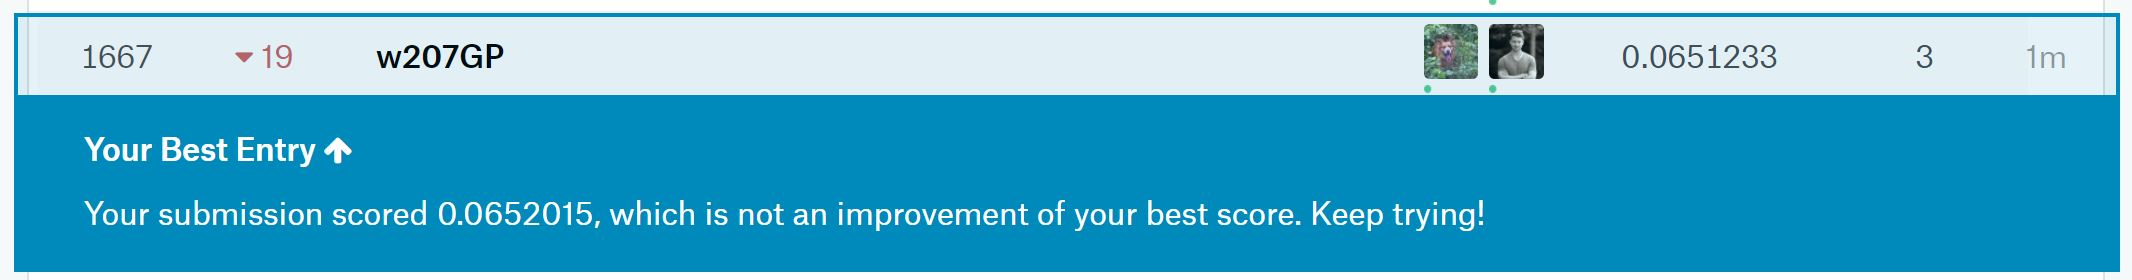

In [22]:
# Results with LightGBM Model and Preprocessing Path1
Image(filename = 'c:/Users/User/Documents/Berkeley/machine_learning/Final_Project_Working_Folder/LightGBM_processed1.jpg', width=800, height=300)

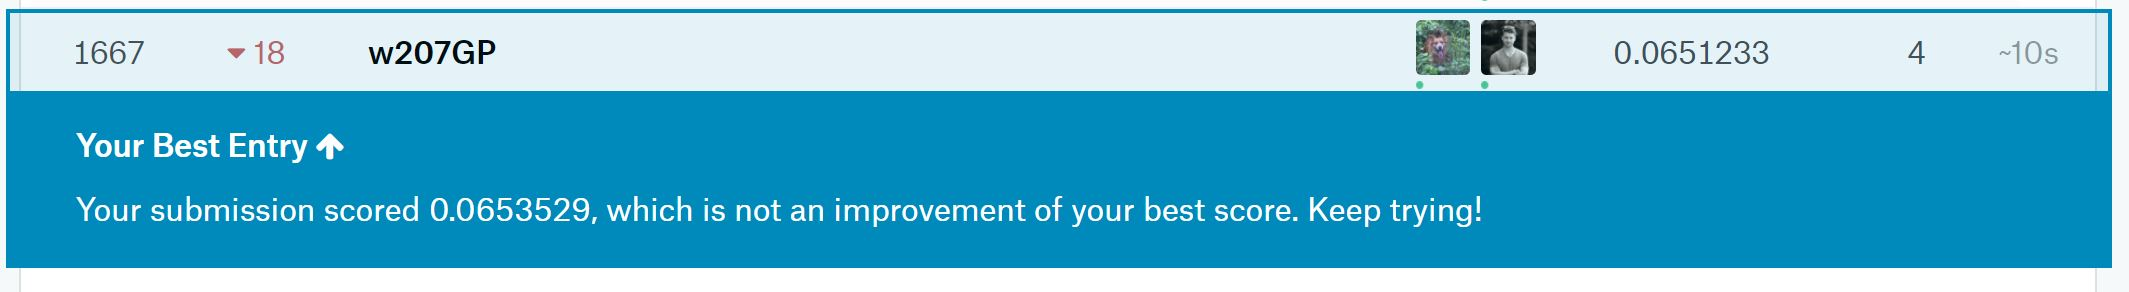

In [24]:
# Results with Decision Tree Model and Preprocessing Path1
Image(filename = 'c:/Users/User/Documents/Berkeley/machine_learning/Final_Project_Working_Folder/DT_processed1.jpg', width=800, height=1000)

Without Imputation...

In [29]:
# Do first couple steps of preprocessing and re-fit LightGBM model and Decision Tree Model

#Feature Creation
train_data3 = feature_creation(train_data)
test_data3 = feature_creation(test_data)

# Remove Strings
train_data3 = remove_strings(train_data3)
test_data3 = remove_strings(test_data3)
train_data3 = preprocessing_step(train_data3) 
test_data3 = preprocessing_step(test_data3) 


# Center and Scale Numerical Variables
train_data3.loc[:,non_cat_variable_names] = scale.transform(train_data3.loc[:,non_cat_variable_names])
test_data3.loc[:,non_cat_variable_names] = scale.transform(test_data3.loc[:,non_cat_variable_names])

train_data3 = np.array(train_data3)
test_data3 = np.array(test_data3)

# Single Fit of a LightGBM Regressor
d_train = lgb.Dataset(train_data3, label=train_labels, free_raw_data=False)
d_test = lgb.Dataset(test_data3, label=test_labels, free_raw_data=False)

params = {}
params['learning_rate'] = 0.002
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['feature_fraction'] = 0.5
params['num_leaves'] = 60
params['min_data_in_leaf'] = 500
params['min_hessian'] = 1
params['lambda_l2'] = 1
params['verbosity'] = -1

start = time.time()
watchlist = [d_test]
GBM3 = lgb.train(params, d_train, 500, watchlist)

GBM3.reset_parameter({"num_threads":1})
GBM3_pred = GBM3.predict(test_data3)
# Show Negative Mean Absolute Error
print("LightGBM Regressor \t\t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, GBM_pred),(time.time()-start)/60))

# Single Fit of a Decision Tree Regressor
start = time.time()
dt3 = DecisionTreeRegressor(criterion = 'mae', max_features = 10, max_depth = 4)
dt3.fit(train_data3, train_labels)
dt_pred = dt3.predict(test_data3)
print("Decision Tree Regressor \t Neg Mean Absolute Error: %0.5f \t Runtime: %0.1f minutes" %(-metrics.mean_absolute_error(test_labels, dt_pred),(time.time()-start)/60))



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

[1]	valid_0's l1: 0.0688152
[2]	valid_0's l1: 0.0688117
[3]	valid_0's l1: 0.0688083
[4]	valid_0's l1: 0.0688064
[5]	valid_0's l1: 0.068805
[6]	valid_0's l1: 0.068803
[7]	valid_0's l1: 0.0687999
[8]	valid_0's l1: 0.068798
[9]	valid_0's l1: 0.0687969
[10]	valid_0's l1: 0.0687943
[11]	valid_0's l1: 0.0687934
[12]	valid_0's l1: 0.0687915
[13]	valid_0's l1: 0.0687889
[14]	valid_0's l1: 0.0687856
[15]	valid_0's l1: 0.0687828
[16]	valid_0's l1: 0.0687804
[17]	valid_0's l1: 0.0687765
[18]	valid_0's l1: 0.0687731
[19]	valid_0's l1: 0.0687711
[20]	valid_0's l1: 0.0687697
[21]	valid_0's l1: 0.0687665
[22]	valid_0's l1: 0.0687642
[23]	valid_0's l1: 0.0687613
[24]	valid_0's l1: 0.0687598
[25]	valid_0's l1: 0.0687567
[26]	valid_0's l1: 0.0687541
[27]	valid_0's l1: 0.0687521
[28]	valid_0's l1: 0.0687495
[29]	valid_0's l1: 0.0687464
[30]	valid_0's l1: 0.0687433
[31]	valid_0's l1: 0.0687416
[32]	valid_0's l1: 0.0687389
[33]	valid_0's l1: 0.0687359
[34]	valid_0's l1: 0.0687334
[35]	valid_0's l1: 0.06873

In [30]:
# Preprocess Test Data & Submit

training_data_for_submission2 = training_data_for_submission.copy()

#Feature Creation
training_data_for_submission2 = feature_creation(training_data_for_submission2)

# Remove Strings
training_data_for_submission2 = remove_strings(training_data_for_submission2)
training_data_for_submission2 = preprocessing_step(training_data_for_submission2) 

# Center and Scale Numerical Variables
training_data_for_submission2.loc[:,non_cat_variable_names] = scale.transform(training_data_for_submission2.loc[:,non_cat_variable_names])

gc.collect()

# Predictions using (change model here)
test_predictions = dt3.predict(training_data_for_submission2)

# Convert to df
test_predictions = pd.DataFrame(test_predictions)

# Assume that the prediction is the same for every month 
test_predictions[1] = test_predictions[0]
test_predictions[2] = test_predictions[0]
test_predictions[3] = test_predictions[0]
test_predictions[4] = test_predictions[0]
test_predictions[5] = test_predictions[0]

# Label Columns
test_predictions.columns = ["201610","201611","201612","201710","201711","201712"]

# Design Output Submission
submission = test_predictions.copy()

# Copy in ParcelId numbers for test set from submission_example file
submission["parcelid"] = submission_example["ParcelId"].copy()
submission.drop_duplicates("parcelid", inplace=True)

# Label Columns
cols = ["parcelid","201610","201611","201612","201710","201711","201712"]
submission = submission[cols]
filename = "Prediction_" + str(submission.columns[0]) + re.sub("[^0-9]", "",str(datetime.datetime.now())) + '.csv'

print(filename)
submission.to_csv(filename,index=False)

Prediction_parcelid20170823153958664444.csv


In [31]:
# Compare to Sample Prediction Template
print(submission.head(10))
print(submission_example.head(10))

print(submission.tail(10))
print(submission_example.tail(10))

   parcelid  201610  201611  201612  201710  201711  201712
0  10754147  2.5440  2.5440  2.5440  2.5440  2.5440  2.5440
1  10759547  0.0020  0.0020  0.0020  0.0020  0.0020  0.0020
2  10843547  0.5636  0.5636  0.5636  0.5636  0.5636  0.5636
3  10859147  0.0149  0.0149  0.0149  0.0149  0.0149  0.0149
4  10879947  0.0020  0.0020  0.0020  0.0020  0.0020  0.0020
5  10898347  0.0149  0.0149  0.0149  0.0149  0.0149  0.0149
6  10933547  0.0020  0.0020  0.0020  0.0020  0.0020  0.0020
7  10940747  0.0149  0.0149  0.0149  0.0149  0.0149  0.0149
8  10954547  2.5440  2.5440  2.5440  2.5440  2.5440  2.5440
9  10976347  0.0149  0.0149  0.0149  0.0149  0.0149  0.0149
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147       0       0       0       0       0       0
1  10759547       0       0       0       0       0       0
2  10843547       0       0       0       0       0       0
3  10859147       0       0       0       0       0       0
4  10879947       0       0       0     

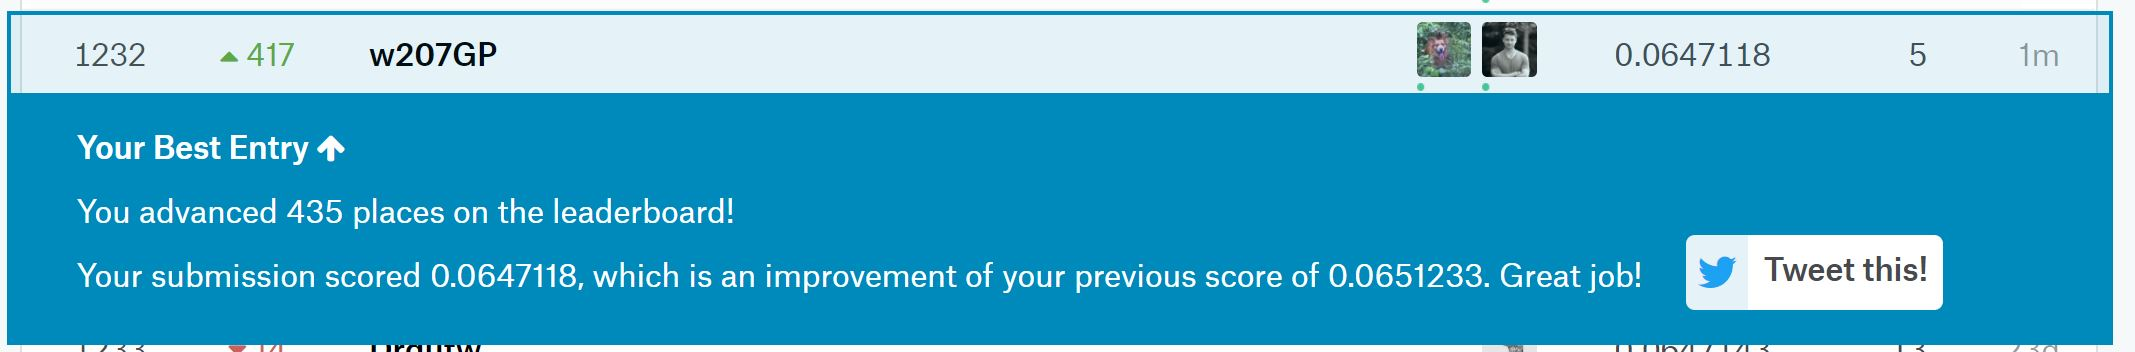

In [26]:
# Results with LightGBM Model and No Imputation
Image(filename = 'c:/Users/User/Documents/Berkeley/machine_learning/Final_Project_Working_Folder/LightGBM_noImpute.jpg', width=800, height=1000)

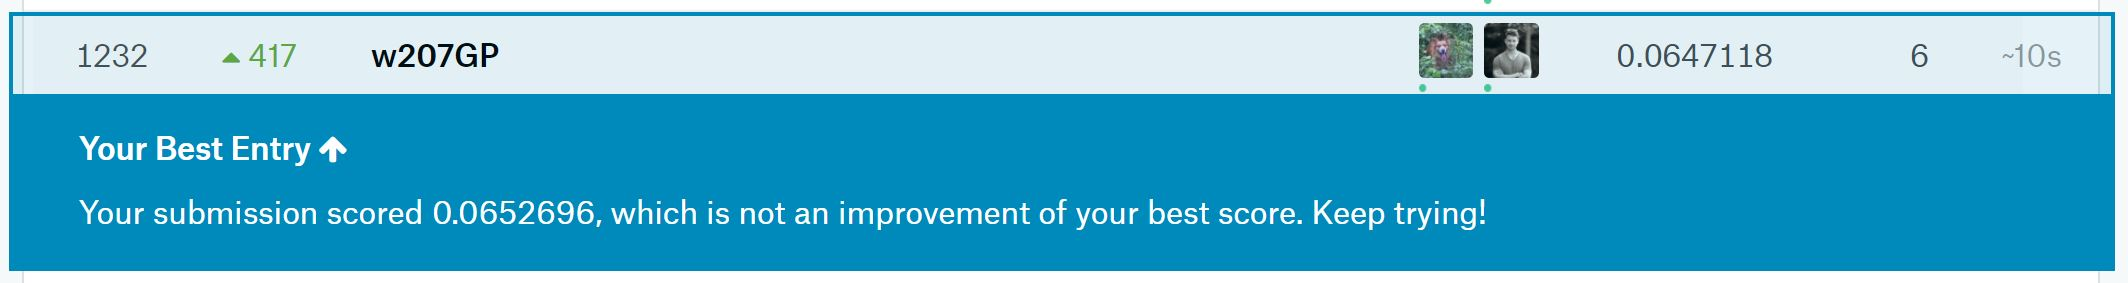

In [27]:
# Results with Decision Tree Model and No Imputation
Image(filename = 'c:/Users/User/Documents/Berkeley/machine_learning/Final_Project_Working_Folder/DT_noImpute.jpg', width=800, height=1000)

# MORE IDEAS
### Use PCA results to identify clusters  (GMM)
### Break Predictions: Identify models that work best for each cluster
### Identify the most weak clusters and run ADA boost with more weight on them
### Conditional KNN with selected features, expanding for new treated features of other variables
